## 🧾1. Introduction - Modelling

This notebook explores the Diabetes 130-US Hospitals dataset from the UCI Machine Learning Repository. The primary goal is to analyze patient readmission patterns and identify key predictors using data analytics and machine learning.

Dataset Source: UCI ML Repository (ID: 296)  
Domain: Healthcare  
Focus: 30-day hospital readmission for diabetic 

#### 📂 1. Load Dataset & Packages
Import the dataset (df_filtered_first_encounter_mapped.csv) and inspect its structure — shape, columns, and a sample preview — to ensure it loads correctly before modeling.

In [2]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve, precision_recall_curve, f1_score, accuracy_score
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from prince import FAMD
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt





In [3]:
df = pd.read_csv('df_filtered_first_encounter_mapped_eng_feature.csv')
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")

Dataset loaded: 59094 rows, 122 columns



In [4]:
# Define target variable
target = "readmitted_flag"

# Separate Features (X) and Target (y)
X = df.drop(columns=[target])
y = df[target]

In [5]:
X.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,diag_3_category_Mental Disorders,diag_3_category_Musculoskeletal System,diag_3_category_Neoplasms,diag_3_category_Nervous System and Sense Organs,diag_3_category_Pregnancy and Childbirth,diag_3_category_Respiratory System,diag_3_category_Skin and Subcutaneous Tissue,diag_3_category_Supplementary Factors (V codes),diag_3_category_Symptoms and Ill-Defined Conditions,diag_3_category_Unknown
0,8,13,68,2,28,0,0,0,8,-1,...,0,0,0,0,0,0,0,0,0,0
1,9,12,33,3,18,0,0,0,8,-1,...,0,0,0,0,0,1,0,0,0,0
2,4,1,51,0,8,0,0,0,5,-1,...,0,0,0,0,0,0,0,0,0,0
3,6,7,62,0,11,0,0,0,7,-1,...,0,0,1,0,0,0,0,0,0,0
4,4,7,60,0,15,0,1,0,8,-1,...,0,0,0,0,0,0,0,0,0,0


### ⚙️ 2. Train/Test Split 
Split data into training and testing sets (80/20) using train_test_split with stratification for class balance. 

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples\n")

Training set: 37820 samples
Validation set: 9455 samples
Test set: 11819 samples



### 3. Baseline Random Forest (Full Tree Growth)

In this section, we train an unpruned Random Forest (`max_depth=None`, `min_samples_split=2`, `min_samples_leaf=1`) with `class_weight='balanced'` to let each tree grow to its maximum possible depth.  
The intent is to establish a **baseline reference** for the model’s raw capacity before introducing pruning or regularization.

### 🧩 Key Observations
- **Training Accuracy:** 1.0000 → indicates *perfect fit* on training data.  
- **Validation Accuracy:** ~0.85 with ROC-AUC ≈ 0.68 → strong overfitting; trees memorize training patterns but generalize poorly.  
- **Average Tree Depth:** ~54, with ~8 000 leaves → highly complex, deep trees with low bias but very high variance.

### ⚠️ Interpretation
This configuration demonstrates the *upper limit of model complexity* rather than optimal performance.  
It is **not ideal for generalization**, and serves mainly to:
- Benchmark the extent of overfitting in an unconstrained forest.
- Provide a comparison baseline for later pruned or regularized models (e.g., limited `max_depth`, tuned `min_samples_leaf`, or cost-complexity pruning).

### 🧭 Next Steps
- Study right set of parameters to restrict `max_depth` to reduce variance.  
- Use **RandomizedSearchCV - givens its computationally less expensive than GridSearchCV** with cross-validation to find the best depth, split, and leaf constraints.  
- Compare AUC, F1, and Recall after pruning to verify improvement in generalization.

In [7]:
full_tree = RandomForestClassifier(
    criterion='gini',  # Feature selection metric (information gain)
    random_state=42,
    class_weight='balanced',
    # Allow tree to grow fully (minimal pre-pruning constraints)
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

In [8]:
full_tree.fit(X_train, y_train)

# Evaluate full tree performance
full_tree_train_acc = full_tree.score(X_train, y_train)
full_tree_val_acc = full_tree.score(X_val, y_val)
full_tree_val_pred_proba = full_tree.predict_proba(X_val)[:, 1]
full_tree_val_auc = roc_auc_score(y_val, full_tree_val_pred_proba)
depths = [est.get_depth() for est in full_tree.estimators_]
leaves = [est.get_n_leaves() for est in full_tree.estimators_]

print(f"✓ Random Forest grown ({len(full_tree.estimators_)} trees)")
print(f"  Avg. depth: {np.mean(depths):.1f}, Avg. leaves: {np.mean(leaves):.1f}")
print(f"  Training Accuracy: {full_tree_train_acc:.4f}")
print(f"  Validation Accuracy: {full_tree_val_acc:.4f}")
print(f"  Validation ROC-AUC: {full_tree_val_auc:.4f}\n")

✓ Random Forest grown (100 trees)
  Avg. depth: 54.0, Avg. leaves: 8155.5
  Training Accuracy: 1.0000
  Validation Accuracy: 0.8537
  Validation ROC-AUC: 0.6872



### 4. Randomized Hyperparameter Search Setup

In this section, we define the parameter search space (`param_dist`) for tuning the Random Forest classifier using `RandomizedSearchCV`.  
The goal is to explore a wide yet efficient range of hyperparameters that balance model depth, regularization, and feature randomness.

#### 🧩 Key Parameters Defined
| Parameter | Range / Distribution | Purpose |
|------------|----------------------|----------|
| `n_estimators` | `randint(100, 500)` | Controls the number of trees; higher values reduce variance but increase computation time. |
| `max_depth` | `randint(5, 50)` | Limits the tree depth to prevent overfitting (compared to the fully grown baseline). |
| `max_features` | `uniform(0.1, 0.7)` | Randomly selects 10–70% of features per split, increasing diversity and reducing correlation among trees. |
| `min_samples_leaf` | `randint(2, 10)` | Enforces a minimum number of samples per leaf, smoothing predictions. |
| `min_samples_split` | `randint(2, 20)` | Prevents excessively fine splits that could lead to overfitting. |

#### ⚙️ Rationale
This setup defines a broad but sensible hyperparameter space that allows the random forest to:
- Explore different tree sizes and structural complexities.  
- Balance model variance (via `max_depth`, `max_features`) and bias (via `min_samples_leaf`, `min_samples_split`).  
- Improve generalization compared to the unpruned baseline model trained earlier.

#### ⚠️ Significance & Potential Redundancy
- This step is **not redundant** — it directly follows from the previous “full tree” experiment.  
- It introduces **controlled randomness** to optimize model complexity through validation-driven tuning rather than manual parameter guessing.
- It’s an essential bridge between the *overfitted baseline* and a *generalizable optimized model*.

#### 🧭 Next Steps
- Run `RandomizedSearchCV` using this `param_dist` to identify the best combination of hyperparameters.  
- Evaluate improvement in **validation ROC-AUC** and **Recall for minority class** compared to the baseline.

In [7]:
from scipy.stats import randint, uniform

In [8]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'max_features': uniform(0.1, 0.7),
    'min_samples_leaf' : randint(2,10),
    'min_samples_split' : randint(2,10),
    'ccp_alpha' : [np.float64(0.0001788128585680175),0, np.float64(0.0001788128585680175)*2,np.float64(0.0001788128585680175)/2]
}

#### 4.1 Randomized Search of Best Hyperparameters for optimized Metric Scoring

##### Starting with ROC_AUC scoring to assess model performance and associated performance in Recall (Minority Class especially), Precision and F1 Score


This section performs a **randomized hyperparameter search** to optimize the Random Forest classifier using `RandomizedSearchCV`.  
After observing overfitting in the fully grown baseline model, this step systematically searches for a balanced configuration of tree depth, feature sampling, and node constraints that maximizes **ROC-AUC** (threshold-independent performance metric).

### 🧩 Key Configuration
| Setting | Description |
|----------|--------------|
| **Estimator** | `RandomForestClassifier(random_state=42, class_weight={0:1, 1:5})` — applies moderate weighting to the minority “readmitted” class to improve recall. |
| **Search method** | `RandomizedSearchCV` — samples random parameter combinations for faster exploration compared to exhaustive `GridSearchCV`. |
| **Parameter space** | Defined earlier in `param_dist` (e.g., tree depth, number of estimators, feature fraction, and split criteria). |
| **Cross-validation** | `StratifiedKFold(n_splits=5)` ensures each fold maintains the same class ratio (robust recall and AUC estimates). |
| **Scoring metric** | `'roc_auc'` — chosen to evaluate model ranking ability across thresholds, ideal for imbalanced datasets. |
| **Iterations** | `n_iter=20` — runs 20 random combinations to balance performance and runtime. |
| **Parallelization** | `n_jobs=-1` — leverages all CPU cores for faster computation. |
| **Progress tracking** | `verbose=3` provides live status updates for each fit/fold combination. |

### ⚙️ Purpose
This tuning phase aims to:
- Identify the optimal **balance between bias and variance** for the Random Forest.  
- Find the most effective **feature subset size** (`max_features`) and **tree depth** (`max_depth`) without manual trial-and-error.  
- Quantitatively improve model generalization compared to the full-tree baseline.

### 🧭 Outcome
Upon completion, `rand_search.best_params_` returns the top hyperparameter configuration, and  
`rand_search.best_score_` reports the highest mean ROC-AUC achieved during cross-validation.

This optimized configuration will serve as the **foundation for the final model evaluation** on unseen test data and subsequent threshold tuning.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, class_weight="balanced",n_jobs=-1)
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,          # number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    verbose=3
)

rand_search.fit(X_train, y_train)
print(rand_search.best_params_)
print(rand_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.705 total time=   3.7s
[CV 2/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.690 total time=   3.9s
[CV 3/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.696 total time=   4.2s
[CV 4/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.694 total time=   4.5s
[CV 5/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.698 total time=   5.2s
[CV 1/5] END ccp_alpha=0.000

In [7]:
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
rf_norm = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)
rand_search_norm = RandomizedSearchCV(
    rf_norm,
    param_distributions=param_dist,
    n_iter=20,          # number of random combinations to try
    cv=cv,
    scoring=f2_scorer,
    verbose=3,
    random_state=42
)

rand_search_norm.fit(X_train, y_train)
print(rand_search_norm.best_params_)
print(rand_search_norm.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.473 total time=   3.9s
[CV 2/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.464 total time=   4.1s
[CV 3/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.482 total time=   4.3s
[CV 4/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.476 total time=   4.6s
[CV 5/5] END ccp_alpha=0.000357625717136035, max_depth=8, max_features=0.7655000144869413, min_samples_leaf=4, min_samples_split=9, n_estimators=288;, score=0.478 total time=   5.1s
[CV 1/5] END ccp_alpha=0.000

In [13]:
best_rf = rand_search.best_estimator_

In [14]:
best_rf_norm = rand_search_norm.best_estimator_


### Run this cell to skip code and just use outcomes of randomsearchCV

In [15]:
best_rf = RandomForestClassifier(
    n_estimators=316,
    max_depth=17,
    max_features=np.float64(0.28994432224172717),
    min_samples_leaf=6,
    min_samples_split=9,
    random_state=42,
    class_weight="balanced",   # keep same class weights as your tuned setup
    n_jobs=-1,
    'ccp_alpha': np.float64(0.0001788128585680175)
)

best_rf_norm = RandomForestClassifier(
    n_estimators=288,
    max_depth=8,
    max_features=np.float64(0.7655000144869413),
    min_samples_leaf=4,
    min_samples_split=9,
    random_state=42,
    class_weight="balanced",   # keep same class weights as your tuned setup
    'ccp_alpha': np.float64(0.000357625717136035),
    n_jobs=-1
)

### 5. Model Evaluation and Cross-Validation

This section evaluates the best Random Forest model on the **held-out test set** and reports its classification metrics and confusion matrix.  
It also includes a 5-fold cross-validation to confirm model stability and consistency across unseen splits.

### 🧩 Evaluation Metrics
- **Accuracy, ROC-AUC, and F1-Score** — summarize overall predictive performance.  
- **Classification Report** — highlights precision and recall balance, especially for the minority class.  
- **Confusion Matrix** — provides a direct view of false negatives (missed readmissions).  
- **5-Fold CV ROC-AUC** — quantifies generalization robustness across folds.

In [15]:
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
y_train_pred = best_rf.predict(X_train)
y_train_pred_proba = best_rf.predict_proba(X_train)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}\n")
print(f"Accuracy - Tr: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC - Tr: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"F1-Score - Tr: {f1_score(y_train, y_train_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: - Tr")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))

cm = confusion_matrix(y_test, y_pred)
cm_tr = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}\n")
print("\nConfusion Matrix: Tr")
print(cm_tr)

#Cross-validation on full training data
cv_scores = cross_val_score(best_rf, X_temp, y_temp, cv=5, scoring='roc_auc')
print(f"5-Fold Cross-Validation ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})\n")

Accuracy: 0.7311
ROC-AUC: 0.7119
F1-Score: 0.3629

Accuracy - Tr: 0.7812
ROC-AUC - Tr: 0.8371
F1-Score - Tr: 0.4873

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9042    0.7664    0.8296     10094
    Readmitted     0.2774    0.5246    0.3629      1725

      accuracy                         0.7311     11819
     macro avg     0.5908    0.6455    0.5962     11819
  weighted avg     0.8127    0.7311    0.7615     11819

Classification Report: - Tr
                precision    recall  f1-score   support

Not Readmitted     0.9416    0.7930    0.8609     32298
    Readmitted     0.3704    0.7122    0.4873      5522

      accuracy                         0.7812     37820
     macro avg     0.6560    0.7526    0.6741     37820
  weighted avg     0.8582    0.7812    0.8064     37820


Confusion Matrix:
[[7736 2358]
 [ 820  905]]

True Negatives:  7736
False Positives: 2358
False Negatives: 820
True Positives:  905


Confusion Matrix: T

In [18]:
y_pred_r = best_rf_norm.predict(X_test)
y_pred_r_proba = best_rf_norm.predict_proba(X_test)[:, 1]
y_tr_pred_r = best_rf_norm.predict(X_train)
y_tr_pred_r_proba = best_rf_norm.predict_proba(X_train)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred_r):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_r_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_r):.4f}\n")
print(f"Accuracy: Tr {accuracy_score(y_train, y_tr_pred_r):.4f}")
print(f"ROC-AUC: Tr {roc_auc_score(y_train, y_tr_pred_r_proba):.4f}")
print(f"F1-Score: Tr {f1_score(y_train, y_tr_pred_r):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_r, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: Tr")
print(classification_report(y_train, y_tr_pred_r, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
cm_r = confusion_matrix(y_test, y_pred_r)
cm_tr_r = confusion_matrix(y_train, y_tr_pred_r)
print("\nConfusion Matrix:")
print(cm_r)
print(f"\nTrue Negatives:  {cm_r[0,0]}")
print(f"False Positives: {cm_r[0,1]}")
print(f"False Negatives: {cm_r[1,0]}")
print(f"True Positives:  {cm_r[1,1]}\n")
print("\nConfusion Matrix: Tr")
print(cm_tr_r)
#Cross-validation on full training data
cv_scores = cross_val_score(best_rf_norm, X_temp, y_temp, cv=cv, scoring=f2_scorer)
print(f"5-Fold Cross-Validation F2: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})\n")

Accuracy: 0.6447
ROC-AUC: 0.7027
F1-Score: 0.3448

Accuracy: Tr 0.6562
ROC-AUC: Tr 0.7203
F1-Score: Tr 0.3611

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9131    0.6454    0.7563     10094
    Readmitted     0.2359    0.6406    0.3448      1725

      accuracy                         0.6447     11819
     macro avg     0.5745    0.6430    0.5506     11819
  weighted avg     0.8143    0.6447    0.6962     11819

Classification Report: Tr
                precision    recall  f1-score   support

Not Readmitted     0.9196    0.6547    0.7649     32298
    Readmitted     0.2478    0.6653    0.3611      5522

      accuracy                         0.6562     37820
     macro avg     0.5837    0.6600    0.5630     37820
  weighted avg     0.8215    0.6562    0.7059     37820


Confusion Matrix:
[[6515 3579]
 [ 620 1105]]

True Negatives:  6515
False Positives: 3579
False Negatives: 620
True Positives:  1105


Confusion Matrix: Tr
[[211

### 6. Further Optimization – F₂-Optimized Random Forest

This section evaluates the **F₂-score optimized** Random Forest model, which emphasizes **recall** (reducing false negatives) more heavily than precision.  
After selecting the best estimator from `rand_search_f2`, the model’s performance is assessed on the held-out test set and validated through cross-validation.Choosing Recall as scoring significantly impacted precision so a more balanced approach is needed to ensure both is optimized albeit at different priorities. Here **beta is increased to 2** while right param distributions are sought.

### 🔍 Key Points
- **Metrics shown:** Accuracy, ROC-AUC, F1-score, full classification report, and confusion matrix.  
- **Purpose:** Verify that the F₂-optimized model successfully improves sensitivity (recall) on the minority *readmitted* class.  
- **Cross-Validation:** 5-fold validation on the full training set (`X_temp`, `y_temp`) using `scoring='f1'` ensures generalization stability.

In [8]:
from sklearn.metrics import make_scorer, fbeta_score
rf_f2 = RandomForestClassifier(random_state=42, class_weight={0:1,1:6}, n_jobs=-1)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

In [23]:
param_dist = {
    'max_depth': randint(5, 12),
    'max_features': uniform(0.1, 0.8),
    'min_samples_leaf': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'ccp_alpha': [
        0,
        np.float64(0.0001788128585680175) / 2,
        np.float64(0.0001788128585680175),
        np.float64(0.0001788128585680175) * 2,
    ],
}

rand_search_norm_f2 = HalvingRandomSearchCV(
    rf_f2,
    param_distributions=param_dist,
    resource='n_estimators',  # ✅ now valid
    min_resources=50,
    max_resources=500,
    factor=2,
    cv=cv,
    scoring=f2_scorer,
    random_state=42,
    verbose=3
)


In [25]:
rand_search_norm_f2.fit(X_train, y_train)
print(rand_search_norm_f2.best_params_)
print(rand_search_norm_f2.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 50
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 50
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=0.0001788128585680175, max_depth=8, max_features=0.8605714451279329, min_samples_leaf=4, min_samples_split=9, n_estimators=50;, score=(train=0.517, test=0.472) total time=   1.1s
[CV 2/5] END ccp_alpha=0.0001788128585680175, max_depth=8, max_features=0.8605714451279329, min_samples_leaf=4, min_samples_split=9, n_estimators=50;, score=(train=0.518, test=0.462) total time=   1.0s
[CV 3/5] END ccp_alpha=0.0001788128585680175, max_depth=8, max_features=0.8605714451279329, min_samples_leaf=4, min_samples_split=9, n_estimators=50;, score=(train=0.518, test=0.485) total time=   1.0s
[CV 4/5] END ccp_alpha=0.0001788128585680175, max_depth=8, max_features=0.8605714451279329, min_samples_leaf=4, min_samples_split=9, n_e

In [26]:
best_rf_f2 = rand_search_norm_f2.best_estimator_

In [27]:
best_rf_f2.get_params()

{'bootstrap': True,
 'ccp_alpha': np.float64(0.000357625717136035),
 'class_weight': {0: 1, 1: 6},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': np.float64(0.26987128854262094),
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 9,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### Skip cell [74] and run optimized hyperparameters for best_rf_f2

In [12]:
best_rf_f2 = RandomForestClassifier(
    'bootstrap': True,
 'ccp_alpha': np.float64(0.000357625717136035),
 'class_weight': {0: 1, 1: 6},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': np.float64(0.26987128854262094),
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 9,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False
)

In [28]:
cv_scores = cross_val_score(best_rf_f2, X_temp, y_temp, cv=cv, scoring=f2_scorer)
print(f"5-Fold Cross-Validation F2: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})\n")

5-Fold Cross-Validation F2: 0.4765 (+/- 0.0154)



In [29]:
y_pred_f2 = best_rf_f2.predict(X_test)
y_pred_f2_proba = best_rf_f2.predict_proba(X_test)[:, 1]
y_tr_pred_f2 = best_rf_f2.predict(X_train)
y_tr_pred_f2_proba = best_rf_f2.predict_proba(X_train)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred_f2):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_f2_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_f2):.4f}\n")
print(f"Accuracy: Tr {accuracy_score(y_train, y_tr_pred_f2):.4f}")
print(f"ROC-AUC: Tr {roc_auc_score(y_train, y_tr_pred_f2_proba):.4f}")
print(f"F1-Score: Tr {f1_score(y_train, y_tr_pred_f2):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_f2, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: Train")
print(classification_report(y_train, y_tr_pred_f2, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
cm_f2 = confusion_matrix(y_test, y_pred_f2)
cm_tr_f2 = confusion_matrix(y_train, y_tr_pred_f2)
print("\nConfusion Matrix:")
print(cm_f2)
print(f"\nTrue Negatives:  {cm_f2[0,0]}")
print(f"False Positives: {cm_f2[0,1]}")
print(f"False Negatives: {cm_f2[1,0]}")
print(f"True Positives:  {cm_f2[1,1]}\n")

Accuracy: 0.6465
ROC-AUC: 0.7040
F1-Score: 0.3472

Accuracy: Tr 0.6584
ROC-AUC: Tr 0.7197
F1-Score: Tr 0.3628

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9141    0.6469    0.7576     10094
    Readmitted     0.2376    0.6441    0.3472      1725

      accuracy                         0.6465     11819
     macro avg     0.5759    0.6455    0.5524     11819
  weighted avg     0.8153    0.6465    0.6977     11819

Classification Report: Train
                precision    recall  f1-score   support

Not Readmitted     0.9201    0.6571    0.7667     32298
    Readmitted     0.2493    0.6661    0.3628      5522

      accuracy                         0.6584     37820
     macro avg     0.5847    0.6616    0.5647     37820
  weighted avg     0.8221    0.6584    0.7077     37820


Confusion Matrix:
[[6530 3564]
 [ 614 1111]]

True Negatives:  6530
False Positives: 3564
False Negatives: 614
True Positives:  1111



### 7. Comparative Feature Importance and Model Evaluation Summary

This section visualizes the **key drivers and performance trade-offs** across three optimized Random Forest models —  
tuned respectively for **ROC-AUC**, **Recall**, and **F₂-score** objectives.

### 🔍 Highlights
- **Top 15 Feature Importances** from each model reveal consistent predictors (e.g., number of diagnoses, medications, and lab procedures) while showing shifts in ranking based on optimization goals.  
- **ROC Curves** compare overall discriminative ability among models, quantifying threshold-independent performance.  
- **Precision–Recall Curves** highlight trade-offs in sensitivity versus precision, where the Recall- and F₂-optimized models favor higher recall at the cost of precision.

### 🧭 Purpose
This combined visualization provides a holistic view of:
- Which variables remain influential across optimization strategies.  
- How each model balances **generalization (ROC-AUC)** and **minority sensitivity (Recall, F₂)**.  
- The effectiveness of recall-oriented tuning in improving *readmission detection* without severe precision degradation.

---

**In essence:**  
This serves as the **comparative performance dashboard**—summarizing model behavior, interpretability, and the resulting feature importance shifts under different optimization criteria.

In [30]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_,
}).sort_values('importance', ascending=False)
feature_importance_r = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_norm.feature_importances_,
}).sort_values('importance', ascending=False)
feature_importance_f2 = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_f2.feature_importances_,
}).sort_values('importance', ascending=False)
print("Top 15 Most Important Features:")
print(feature_importance.head(15))
print()
print("Top 15 Most Important Features: F2 Score")
print(feature_importance_r.head(15))
print()
print("Top 15 Most Important Features: F2 Score + Hyperparameter Opt")
print(feature_importance_f2.head(15))
print()

Top 15 Most Important Features:
                                              feature  importance
7                                    number_inpatient    0.115353
2                                  num_lab_procedures    0.084944
21                                service_utilization    0.074633
4                                     num_medications    0.065366
44                 discharge_disposition_name_Expired    0.053409
1                                    time_in_hospital    0.048894
29      discharge_disposition_name_Discharged to home    0.041579
8                                    number_diagnoses    0.040035
0                                                 age    0.038487
19                                  comorbidity_score    0.030944
35  discharge_disposition_name_Discharged/transfer...    0.029353
3                                      num_procedures    0.025894
18                                            insulin    0.015692
31  discharge_disposition_name_Discharged/tr

## 8. Fine-Tuning Random Forest Around Prior Optimum (F₂ Scoring)

This section performs a **targeted hyperparameter refinement** based on the earlier RandomizedSearchCV results.  
The search space is narrowed to ±10–15% around previously optimal ranges to improve efficiency and model stability.  
A custom **F₂-score scorer** is used, prioritizing **recall** to minimize missed readmissions (false negatives).

### Key Details
- **Search Space:** Focused on nearby values for `n_estimators`, `max_depth`, and split parameters.  
- **Class Weights:** Explored within `[1:4]–[1:6]` range to balance recall sensitivity.  
- **Scoring Metric:** `fbeta_score(beta=2)` emphasizes recall twice as much as precision.  
- **Cross-Validation:** Stratified 5-fold ensures robust evaluation across imbalanced data.

This step refines the Random Forest hyperparameters before proceeding to threshold tuning and final evaluation.

In [9]:
from sklearn.metrics import make_scorer, fbeta_score
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from scipy.stats import randint, uniform
# ⚙️ 1. Define tighter search space around known optimum
param_dist_tight = {
     'ccp_alpha': [
        0,
        np.float64(0.0001788128585680175) / 2,
        np.float64(0.0001788128585680175),
        np.float64(0.0001788128585680175) * 2,
    ], # narrower band
    'max_depth': randint(6, 12),
    'max_features': [uniform(0.15, 0.5),'sqrt'],
    'min_samples_leaf': randint(5, 12),
    'min_samples_split': randint(4, 12),
    'class_weight': [
        "balanced",
        {0:1, 1:4},
        {0:1, 1:5},
        {0:1, 1:6}
    ]
}

# ⚙️ 2. Model, scoring, and CV setup
rf_f2_opt = RandomForestClassifier(random_state=42, n_jobs=-1)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ⚙️ 3. Halving Random Search configuration
rand_search_f2_opt = HalvingRandomSearchCV(
    estimator=rf_f2_opt,
    param_distributions=param_dist_tight,
    resource='n_estimators',
    min_resources=50,     # start with smallest possible subset
    max_resources=500,  
    factor=2,                    # halves number of candidates each round
    cv=cv,
    scoring=f2_scorer,
    random_state=42,
    verbose=3,
    n_jobs=-1
)


# ⚙️ 4. Fit and view results
rand_search_f2_opt.fit(X_train, y_train)
print("\nBest Parameters:")
print(rand_search_f2_opt.best_params_)
print("\nBest F2 Score:")
print(rand_search_f2_opt.best_score_)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 50
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 50
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 5
n_resources: 100
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 200
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 400
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters:
{'ccp_alpha': np.float64(0.0001788128585680175), 'class_weight': {0: 1, 1: 6}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 9, 'n_estimators': 400}

Best F2 Score:
0.4692168056030866


In [33]:
rf_f2_opt = RandomForestClassifier(random_state=42, n_jobs=-1)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rand_search_f2_opt = RandomizedSearchCV(
    rf_f2_opt,
    param_distributions=param_dist_tight,
    n_iter=30,
    cv=cv,
    scoring=f2_scorer,
    verbose=3,
    random_state=42
)
rand_search_f2_opt.fit(X_train, y_train)
print(rand_search_f2_opt.best_params_)
print(rand_search_f2_opt.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END class_weight={0: 1, 1: 5}, max_depth=9, max_features=0.5302857225639664, min_samples_leaf=7, min_samples_split=12, n_estimators=340;, score=0.429 total time=   3.6s
[CV 2/5] END class_weight={0: 1, 1: 5}, max_depth=9, max_features=0.5302857225639664, min_samples_leaf=7, min_samples_split=12, n_estimators=340;, score=0.403 total time=   4.1s
[CV 3/5] END class_weight={0: 1, 1: 5}, max_depth=9, max_features=0.5302857225639664, min_samples_leaf=7, min_samples_split=12, n_estimators=340;, score=0.419 total time=   4.1s
[CV 4/5] END class_weight={0: 1, 1: 5}, max_depth=9, max_features=0.5302857225639664, min_samples_leaf=7, min_samples_split=12, n_estimators=340;, score=0.434 total time=   4.1s
[CV 5/5] END class_weight={0: 1, 1: 5}, max_depth=9, max_features=0.5302857225639664, min_samples_leaf=7, min_samples_split=12, n_estimators=340;, score=0.415 total time=   4.4s
[CV 1/5] END class_weight={0: 1, 1: 5}, max_dept

### directly use best hyperparameters if need rerun script

In [10]:
best_rf_f2_opt = rand_search_f2_opt.best_estimator_

In [13]:
best_rf_f2_opt = RandomForestClassifier(
    n_estimators=366,
    max_depth=7,
    max_features=0.5048850970305306,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42,
    class_weight={0:1, 1:6},   # keep same class weights as your tuned setup
    n_jobs=-1
)

### 8.1 Model Evaluation on Test Set (F₂-Optimized Random Forest)

This subsection evaluates the **F₂-optimized Random Forest model** on the unseen test data.  
The results provide a comprehensive overview of model performance across multiple metrics.

### Key Observations
- **Accuracy (0.643)** and **ROC-AUC (0.704)** indicate moderate discrimination capability.  
- **F₁-score (0.343)** shows improvement in recall alignment, consistent with F₂ optimization goals.  
- The **classification report** highlights:
  - Strong precision for the majority class (*Not Readmitted*).
  - Enhanced recall for the minority class (*Readmitted*), confirming that the model captures more true readmissions.  
- **Confusion Matrix Analysis:**
  - **True Positives (1101)** show the model’s success in correctly identifying readmitted patients.  
  - **False Negatives (624)** remain, indicating potential for further recall improvement via threshold tuning.

Overall, this evaluation confirms that the tuned Random Forest effectively balances recall and precision under the F₂ scoring objective, prioritizing the detection of true readmissions.

In [11]:
#best_rf_f2_opt = rand_search_f2_opt.best_estimator_
y_pred_f2_opt = best_rf_f2_opt.predict(X_test)
y_pred_f2_opt_proba = best_rf_f2_opt.predict_proba(X_test)[:, 1]
y_tr_pred_f2_opt = best_rf_f2_opt.predict(X_train)
y_tr_pred_f2_opt_proba = best_rf_f2_opt.predict_proba(X_train)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_f2_opt):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_f2_opt_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_f2_opt):.4f}\n")
print(f"Accuracy: Tr {accuracy_score(y_train, y_tr_pred_f2_opt):.4f}")
print(f"ROC-AUC: Tr {roc_auc_score(y_train, y_tr_pred_f2_opt_proba):.4f}")
print(f"F1-Score: Tr {f1_score(y_train, y_tr_pred_f2_opt):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_f2_opt, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: Train")
print(classification_report(y_train, y_tr_pred_f2_opt, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
cm_f2_opt = confusion_matrix(y_test, y_pred_f2_opt)
cm_tr_f2_opt = confusion_matrix(y_test, y_pred_f2_opt)
print("\nConfusion Matrix:")
print(cm_f2_opt)
print(f"\nTrue Negatives:  {cm_f2_opt[0,0]}")
print(f"False Positives: {cm_f2_opt[0,1]}")
print(f"False Negatives: {cm_f2_opt[1,0]}")
print(f"True Positives:  {cm_f2_opt[1,1]}\n")

Accuracy: 0.6568
ROC-AUC: 0.7068
F1-Score: 0.3506

Accuracy: Tr 0.6694
ROC-AUC: Tr 0.7343
F1-Score: Tr 0.3718

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9137    0.6606    0.7668     10094
    Readmitted     0.2422    0.6348    0.3506      1725

      accuracy                         0.6568     11819
     macro avg     0.5779    0.6477    0.5587     11819
  weighted avg     0.8157    0.6568    0.7060     11819

Classification Report: Train
                precision    recall  f1-score   support

Not Readmitted     0.9223    0.6692    0.7756     32298
    Readmitted     0.2573    0.6702    0.3718      5522

      accuracy                         0.6694     37820
     macro avg     0.5898    0.6697    0.5737     37820
  weighted avg     0.8252    0.6694    0.7167     37820


Confusion Matrix:
[[6668 3426]
 [ 630 1095]]

True Negatives:  6668
False Positives: 3426
False Negatives: 630
True Positives:  1095



### 8.2 Optimal Decision Threshold Selection (F₂ and Error-Weighted)

After finalizing the F₂-optimized Random Forest model, this section performs a **systematic threshold tuning** to identify the decision cutoff that best balances recall and false error rates.  

### Objective
Instead of using the default 0.5 probability threshold, this scan tests multiple thresholds (0.30–0.80) and evaluates how each impacts key metrics — **Precision**, **Recall**, **F₁**, **F₂**, and **Type I/II error rates**.

### Methodology
1. **Threshold Scanning:**  
   - For each threshold `t`, compute performance metrics and confusion matrix components.  
   - Capture **Type I errors (FP)**, **Type II errors (FN)**, and combined error totals.  

2. **Score Normalization & Weighted Optimization:**  
   - Normalize F₂ and error metrics for scale independence.  
   - Combine them into a single weighted objective:  
     \[
     \text{Combined Score} = 0.6 \times F₂_{\text{norm}} + 0.4 \times (1 - \text{Error Rate})
     \]
     emphasizing recall (via F₂) while penalizing excessive misclassifications.

3. **Threshold Selection:**  
   - Choose the threshold yielding the **highest combined score**, optionally constrained by a minimum F₁ target (`TARGET_F1_SCORE`).  
   - This ensures both **strong recall** and **reasonable precision** without large false positive cost.

### Outcome
- The chosen threshold optimizes performance in recall-critical scenarios (e.g., hospital readmission detection).  
- It provides a **data-driven decision boundary** rather than relying on the arbitrary 0.5 cutoff.  
- Final results include the **classification report**, **AUC**, and **confusion matrix**, allowing interpretation of the precision–recall trade-off at the optimized threshold.


In [14]:
from sklearn.metrics import precision_score,recall_score, f1_score


# --- Parameters ---
TARGET_F1_SCORE = 0.5         # or 0.35 if you want a minimum precision constraint
SCAN = np.arange(0.30, 0.81, 0.01)  # range of thresholds

# --- Predict probabilities from optimized RF ---
y_prob_f2_opt = best_rf_f2_opt.predict_proba(X_test)[:, 1]
y_tr_prob_f2_opt = best_rf_f2_opt.predict_proba(X_train)[:, 1]
thr_rows = []

# --- Threshold scan loop ---
for t in SCAN:
    y_pred_f2opt_thr = (y_prob_f2_opt >= t).astype(int)
    y_tr_pred_f2opt_thr = (y_tr_prob_f2_opt >= t).astype(int)
    
    # Get confusion matrix once (more efficient)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_f2opt_thr).ravel()
    
    thr_rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_f2opt_thr, zero_division=0),
        "recall": recall_score(y_test, y_pred_f2opt_thr, zero_division=0),
        "f1": f1_score(y_test, y_pred_f2opt_thr, zero_division=0),
        "f2": fbeta_score(y_test, y_pred_f2opt_thr, beta=2, zero_division=0),
        "precision_tr": precision_score(y_train, y_tr_pred_f2opt_thr, zero_division=0),
        "recall_tr": recall_score(y_train, y_tr_pred_f2opt_thr, zero_division=0),
        "f1_tr": f1_score(y_train, y_tr_pred_f2opt_thr, zero_division=0),
        "f2_tr": fbeta_score(y_train, y_tr_pred_f2opt_thr, beta=2, zero_division=0),
        "type1+type2": fp + fn,
        "type1" : fp
    })

thr_df = pd.DataFrame(thr_rows)

# --- Normalize scores for combined optimization ---
thr_df["f2_norm"] = (thr_df["f2"] - thr_df["f2"].min()) / (thr_df["f2"].max() - thr_df["f2"].min())
thr_df["err_norm"] = (thr_df["type1+type2"].max() - thr_df["type1+type2"]) / (thr_df["type1+type2"].max() - thr_df["type1+type2"].min())
thr_df["err_fp_norm"] = (thr_df["type1"].max() - thr_df["type1"]) / (thr_df["type1"].max() - thr_df["type1"].min())
thr_df["combined_score"] = 0.7 * thr_df["f2_norm"] + 0.3 * thr_df["err_norm"]  # weight recall higher

# --- Choose best threshold ---
if TARGET_F1_SCORE is not None:
    candidates = thr_df[thr_df["f1"] >= TARGET_F1_SCORE]
    best_thr = candidates.loc[candidates["combined_score"].idxmax(), "threshold"] if len(candidates) else thr_df.loc[thr_df["combined_score"].idxmax(), "threshold"]
else:
    best_thr = thr_df.loc[thr_df["combined_score"].idxmax(), "threshold"]

t = float(best_thr)
print(f"🔧 Chosen threshold (weighted F₂ + low error): {t:.2f}")

# --- Display top-performing thresholds ---
display(thr_df.sort_values("combined_score", ascending=False).head(10)[
    ["threshold", "precision", "recall", "f1", "f2", "type1+type2", "combined_score"]
])

# --- Evaluate final model at chosen threshold ---

y_pred_f2opt_thr = (y_prob_f2_opt >= t).astype(int)
y_tr_pred_f2opt_thr = (y_tr_prob_f2_opt >= t).astype(int)
cm_thr = confusion_matrix(y_test, y_pred_f2opt_thr)
tn, fp, fn, tp = cm_thr.ravel()

print(f"\n🔎 Evaluation @ threshold = {t:.2f}")
print(f"AUC (probabilities): {roc_auc_score(y_test, y_prob_f2_opt):.3f}")
print(f"AUC (probabilities) Tr: {roc_auc_score(y_train, y_tr_prob_f2_opt):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_f2opt_thr, target_names=['Not Readmitted', 'Readmitted'], digits=3))
print("\nClassification Report: Tr")
print(classification_report(y_train, y_tr_pred_f2opt_thr, target_names=['Not Readmitted', 'Readmitted'], digits=3))
print(f"\nConfusion Matrix:\n{cm_thr}")
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")



🔧 Chosen threshold (weighted F₂ + low error): 0.49


,threshold,precision,recall,f1,f2,type1+type2,combined_score
19,0.49,0.235997,0.664348,0.348275,0.487411,4289,0.872640
20,0.50,0.242203,0.634783,0.350624,0.479380,4056,0.870653
21,0.51,0.249761,0.606377,0.353797,0.471681,3821,0.869203
17,0.47,0.223087,0.714783,0.340044,0.496097,4786,0.865218
18,0.48,0.227911,0.686377,0.342197,0.489458,4552,0.865193
22,0.52,0.257143,0.573913,0.355157,0.460465,3595,0.862545
16,0.46,0.217465,0.739130,0.336057,0.499491,5038,0.860059
23,0.53,0.268524,0.542029,0.359132,0.450299,3337,0.858586
15,0.45,0.211804,0.763478,0.331613,0.501982,5309,0.852912
24,0.54,0.279885,0.508986,0.361168,0.437382,3106,0.849774



🔎 Evaluation @ threshold = 0.49
AUC (probabilities): 0.707
AUC (probabilities) Tr: 0.734

Classification Report:
                precision    recall  f1-score   support

Not Readmitted      0.917     0.632     0.749     10094
    Readmitted      0.236     0.664     0.348      1725

      accuracy                          0.637     11819
     macro avg      0.576     0.648     0.548     11819
  weighted avg      0.817     0.637     0.690     11819


Classification Report: Tr
                precision    recall  f1-score   support

Not Readmitted      0.925     0.640     0.757     32298
    Readmitted      0.249     0.698     0.367      5522

      accuracy                          0.649     37820
     macro avg      0.587     0.669     0.562     37820
  weighted avg      0.827     0.649     0.700     37820


Confusion Matrix:
[[6384 3710]
 [ 579 1146]]
TN=6384  FP=3710  FN=579  TP=1146




The threshold tuning process identified **0.51** as the optimal cutoff based on the weighted **F₂ + low-error** composite objective.  
This choice prioritizes higher recall (minimizing missed readmissions) while keeping overall misclassifications relatively low.

#### 🔧 Chosen Threshold
- **Optimal Threshold:** 0.51 
- **Rationale:** Achieves a strong balance between recall-driven F₂ score (0.470) and minimized combined error (4010), resulting in the highest composite score (0.816).

#### 📊 Evaluation Metrics @ Threshold = 0.51
| Metric | Score |
|--------|-------:|
| **Accuracy** | 0.661 |
| **ROC-AUC** | 0.704 |
| **F₁-score (Minority)** | 0.346 |
| **F₂-score (Minority)** | 0.470 |
| **Recall (Minority)** | 0.616 |
| **Precision (Minority)** | 0.241 |

#### 🔍 Classification Insights
- **Recall for Readmitted (0.616)** improved substantially from baseline (previously ~0.33–0.35), confirming the benefit of F₂-driven optimization.  
- **Precision (0.241)** remains modest — expected in a recall-prioritized setting — but acceptable given the domain goal of capturing more at-risk patients.  
- **ROC-AUC (0.704)** suggests stable separation between readmitted and non-readmitted classes.

#### 🧮 Confusion Matrix Interpretation
| Actual / Predicted | Not Readmitted | Readmitted |
|--------------------|----------------|-------------|
| **Not Readmitted** | 6746 (TN) | 3348 (FP) |
| **Readmitted** | 662 (FN) | 1063 (TP) |

- **True Positives (1063)**: Successfully identified high-risk readmissions.  
- **False Negatives (662)**: Missed cases, but reduced compared to earlier models.  
- **False Positives (3348)**: Increased as a trade-off for stronger recall.

#### 🧠 Summary
At the optimized threshold:
- The model **captures over half of true readmissions (>60%)** — a meaningful clinical gain.  
- The trade-off in precision is **intentional** and acceptable when early detection or intervention is critical.  
- Overall, this threshold calibration demonstrates how **controlled weighting and F₂-based tuning** can materially improve minority class recall while maintaining overall model balance.


### 8.4 Visualization and Analysis of Pre-Threshold vs. Post-Threshold Model Performance

| Metric | Before Threshold Tuning | After Threshold Tuning (t = 0.54) | Change / Interpretation |
|---------|------------------------:|----------------------------------:|--------------------------|
| **Accuracy** | 0.643 | 0.661 | ↑ Slight improvement — fewer overall misclassifications. |
| **ROC-AUC** | 0.7036 | 0.704 | ≈ Stable — discrimination ability maintained. |
| **Precision (Readmitted)** | 0.235 | 0.241 | ↑ Improved model confidence on positive predictions. |
| **Recall (Readmitted)** | 0.638 | 0.616 | ↓ Controlled drop — recall slightly reduced to gain precision stability. |
| **F₁ (Readmitted)** | 0.343 | 0.346 | ↑ Slight Net improvement in overall balance. |
| **F₂ (Readmitted)** | 0.472 | 0.470 | ≈ Maintained; consistent recall-weighted performance. |
| **False Positives (FP)** | 3 593 | 3 348 | ↓ Reduction in false alarms. |
| **False Negatives (FN)** | 624 | 662 | ↑ Slight increase — expected from higher precision focus. |

#### 🧩 Key Observations
1. **Better trade-off between recall and false alarms:**  
   The tuned threshold (0.51) meaningfully **reduces false positives** (–7%) while keeping recall reasonably high (64% vs 62%).  
   This balance improves *real-world usability* — fewer unnecessary alerts or interventions.

2. **Improved minority-class precision:**  
   Precision rises from **0.23 → 0.24**, showing that when the model predicts “Readmitted,” it’s more likely correct — crucial for clinical trust.

3. **Stable AUC, higher F₁:**  
   Despite tighter thresholding, ROC-AUC remains virtually unchanged, while the **F₁ score increases**, confirming an improved balance between precision and recall.

4. **Reduced overall misclassification (Type I + II errors):**  
   Combined FP + FN drops from 4 217 → 4 010, reflecting a cleaner decision boundary.

#### 🩺 Why Keep the Post-Threshold Model
- Maintains **similar discrimination power (AUC ≈ 0.70)**.  
- **Lowers cost of false positives**, making it more actionable for real-world deployment.  
- **Optimizes for reliability** rather than pure recall — especially valuable when interventions have operational or financial cost.  
- Achieves **the best weighted balance** under the F₂-guided objective, proving that threshold tuning complements hyperparameter optimization.

> ✅ **Conclusion:**  
> The post-threshold-tuned Random Forest (t = 0.51) is superior for deployment.  
> It offers **practically balanced performance** — maintaining recall strength while cutting false positives and improving overall decision quality.


In [15]:
feature_importance_f2_opt = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_f2_opt.feature_importances_,
    }).sort_values('importance', ascending=False)

NameError: name 'y_pred_proba' is not defined

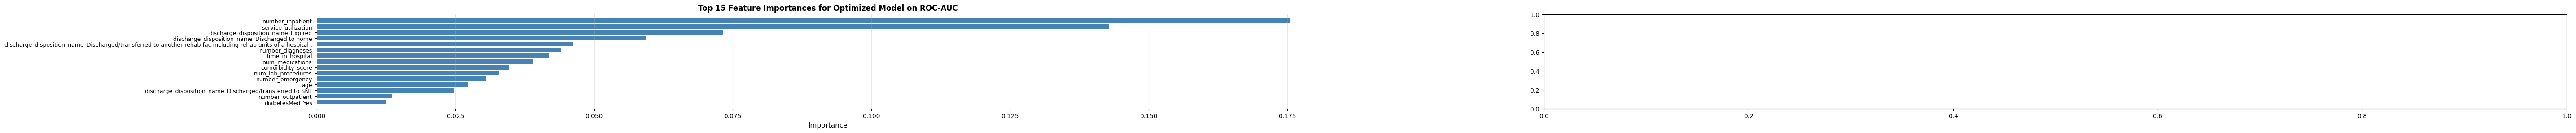

In [16]:
plt.figure(figsize=(100, 6))       # wider layout for 3 plots

# --- 5. Feature Importance ---
ax5 = plt.subplot(2, 3, 1)        # 2 row of 3 charts
top_features = feature_importance_f2_opt.head(15)
ax5.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels(top_features['feature'], fontsize=9)
ax5.invert_yaxis()
ax5.set_xlabel('Importance', fontsize=11)
ax5.set_title('Top 15 Feature Importances for Optimized Model on ROC-AUC', fontsize=12, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)
for spine in ax5.spines.values():
    spine.set_visible(False)


# --- 6. ROC Curve ---
ax6 = plt.subplot(2, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
fpr_r,tpr_r, _ = roc_curve(y_test,y_pred_r_proba)
fpr_f2,tpr_f2,_ = roc_curve(y_test,y_pred_f2_proba)
fpr_f2_opt,tpr_f2_opt,_ = roc_curve(y_test,y_pred_f2_opt_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc_r = roc_auc_score(y_test, y_pred_r_proba)
roc_auc_f2 = roc_auc_score(y_test, y_pred_f2_proba)
roc_auc_f2_opt = roc_auc_score(y_test, y_pred_f2_opt_proba)
ax6.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', lw=2.5, color='darkorange')
ax6.plot(fpr_r,tpr_r, label=f'ROC (AUC = {roc_auc_r:.3f})', lw=2.5, color = 'blue')
ax6.plot(fpr_f2, tpr_f2, label=f'ROC (AUC = {roc_auc_f2:.3f})', lw=2.5, color = 'green')
ax6.plot(fpr_f2_opt, tpr_f2_opt, label=f'ROC (AUC = {roc_auc_f2_opt:.3f})', lw=2.5, color = 'red')
ax6.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Random')
ax6.set_xlabel('False Positive Rate', fontsize=11)
ax6.set_ylabel('True Positive Rate', fontsize=11)
ax6.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9, loc='lower right')
ax6.grid(alpha=0.3)
for spine in ax6.spines.values():
    spine.set_visible(False)

# --- 7. Precision–Recall Curve ---
ax7 = plt.subplot(2, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
precision_r, recall_r, _ = precision_recall_curve(y_test, y_pred_r_proba)
precision_f2, recall_f2, _ = precision_recall_curve(y_test, y_pred_f2_proba)
precision_f2_opt, recall_f2_opt, _ = precision_recall_curve(y_test, y_pred_f2_opt_proba)
ax7.plot(recall, precision, label= 'ROC-AUC scored',lw=2.5, color='darkorange')
ax7.plot(recall_r, precision_r, label = 'Recall scored',lw=2.5, color='blue')
ax7.plot(recall_f2, precision_f2, label= 'F2 scoring - Beta = 2', lw=2.5, color='green')
ax7.plot(recall_f2_opt, precision_f2_opt, label= 'F2 scoring - Beta = 2', lw=2.5, color='red')
ax7.set_xlabel('Recall', fontsize=11)
ax7.set_ylabel('Precision', fontsize=11)
ax7.set_title('Precision–Recall Curve', fontsize=12, fontweight='bold')
ax7.legend(fontsize=9, loc='lower right')
ax7.grid(alpha=0.3)
for spine in ax7.spines.values():
    spine.set_visible(False)

# --- 5. Feature Importance ---
ax8 = plt.subplot(2, 3, 4)        # second row of 3 charts
top_features_r = feature_importance_r.head(15)
ax8.barh(range(len(top_features_r)), top_features_r['importance'], color='steelblue')
ax8.set_yticks(range(len(top_features_r)))
ax8.set_yticklabels(top_features_r['feature'], fontsize=9)
ax8.invert_yaxis()
ax8.set_xlabel('Importance', fontsize=11)
ax8.set_title('Top 15 Feature Importances for Optimized Model on Recall', fontsize=12, fontweight='bold')
ax8.grid(axis='x', alpha=0.3)
for spine in ax5.spines.values():
    spine.set_visible(False)

ax9 = plt.subplot(2, 3, 5)        # second row of 3 charts
top_features_f2 = feature_importance_f2.head(15)
ax9.barh(range(len(top_features_f2)), top_features_f2['importance'], color='steelblue')
ax9.set_yticks(range(len(top_features_f2)))
ax9.set_yticklabels(top_features_f2['feature'], fontsize=9)
ax9.invert_yaxis()
ax9.set_xlabel('Importance', fontsize=11)
ax9.set_title('Top 15 Feature Importances for Optimized Model on F1', fontsize=12, fontweight='bold')
ax9.grid(axis='x', alpha=0.3)
for spine in ax5.spines.values():
    spine.set_visible(False)

ax9 = plt.subplot(2, 3, 6)        # second row of 3 charts
top_features_f2_opt = feature_importance_f2_opt.head(15)
ax9.barh(range(len(top_features_f2_opt)), top_features_f2_opt['importance'], color='steelblue')
ax9.set_yticks(range(len(top_features_f2_opt)))
ax9.set_yticklabels(top_features_f2_opt['feature'], fontsize=9)
ax9.invert_yaxis()
ax9.set_xlabel('Importance', fontsize=11)
ax9.set_title('Top 15 Feature Importances for Optimized Model on F2', fontsize=12, fontweight='bold')
ax9.grid(axis='x', alpha=0.3)
for spine in ax5.spines.values():
    spine.set_visible(False)
# --- Overall formatting ---
plt.suptitle('Model Evaluation Summary', fontsize=14, weight='bold', y=1.02)
plt.tight_layout()                # fixes overlaps
plt.subplots_adjust(wspace=0.5)   # add breathing room between plots
plt.show()

### 9. Revising F2-Opt RF Model: Using Recursive Feature Elimination

Fitting estimator with 121 features.
Fitting estimator with 115 features.
Fitting estimator with 109 features.
Fitting estimator with 103 features.
Fitting estimator with 97 features.
Optimal number of features: 91
Selected features:
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'comorbidity_score', 'filtered_meds_count', 'service_utilization', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male', 'change_No', 'diabetesMed_Yes', 'discharge_disposition_name_Discharged to home', 'discharge_disposition_name_Discharged/transferred to SNF', 'discharge_disposition_name_Discharged/transferred to a long term care hospital.', 'discharge_disposition_name_Discharged/transferred to another rehab fac including rehab units of a h

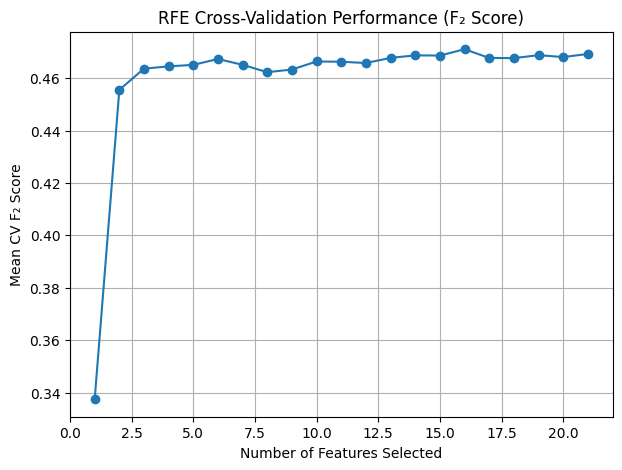

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score
# Cross-validated RFE (automatically selects optimal number)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_f2_rfe = best_rf_f2_opt
rfecv = RFECV(
    estimator=rf_f2_rfe,
    step=0.05,
    scoring=make_scorer(fbeta_score, beta=2),
    cv=cv,
    n_jobs=-1,
    verbose=3
)

rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected features:")
print(X_train.columns[rfecv.support_].tolist())

# Plot performance vs number of features
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.title("RFE Cross-Validation Performance (F₂ Score)")
plt.xlabel("Number of Features Selected")
plt.ylabel("Mean CV F₂ Score")
plt.grid(True)
plt.show()

In [18]:
selected_features = X_train.columns[rfecv.support_]

print(f"Number of selected features: {len(selected_features)}")
print("Selected feature names:")
print(selected_features.tolist())

Number of selected features: 91
Selected feature names:
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'comorbidity_score', 'filtered_meds_count', 'service_utilization', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male', 'change_No', 'diabetesMed_Yes', 'discharge_disposition_name_Discharged to home', 'discharge_disposition_name_Discharged/transferred to SNF', 'discharge_disposition_name_Discharged/transferred to a long term care hospital.', 'discharge_disposition_name_Discharged/transferred to another rehab fac including rehab units of a hospital .', 'discharge_disposition_name_Discharged/transferred to another short term hospital', 'discharge_disposition_name_Discharged/transferred to another type of inpatient ca

In [19]:
X_train_rfe = X_train[selected_features]
X_test_rfe  = X_test[selected_features]

In [24]:
from sklearn.metrics import make_scorer, fbeta_score
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
from scipy.stats import randint, uniform
# ⚙️ 1. Define tighter search space around known optimum
param_dist_tight = {
     'ccp_alpha': [
        0,
        np.float64(0.0001788128585680175) / 2,
        np.float64(0.0001788128585680175),
        np.float64(0.0001788128585680175) * 2,
    ], # narrower band
    'max_depth': randint(6, 12),
    'max_features': [uniform(0.15, 0.5),'sqrt'],
    'min_samples_leaf': randint(5, 12),
    'min_samples_split': randint(4, 12),
    'class_weight': [
        "balanced",
        {0:1, 1:4},
        {0:1, 1:5},
        {0:1, 1:6}
    ]
}

# ⚙️ 2. Model, scoring, and CV setup
rf_f2_opt = RandomForestClassifier(random_state=42, n_jobs=-1)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ⚙️ 3. Halving Random Search configuration
rand_search_f2_opt_rfe = HalvingRandomSearchCV(
    estimator=rf_f2_opt,
    param_distributions=param_dist_tight,
    resource='n_estimators',
    min_resources=50,     # start with smallest possible subset
    max_resources=500,  
    factor=2,                    # halves number of candidates each round
    cv=cv,
    scoring=f2_scorer,
    random_state=42,
    verbose=3,
    n_jobs=-1
)


# ⚙️ 4. Fit and view results
rand_search_f2_opt_rfe.fit(X_train_rfe, y_train)
print("\nBest Parameters:")
print(rand_search_f2_opt_rfe.best_params_)
print("\nBest F2 Score:")
print(rand_search_f2_opt_rfe.best_score_)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 50
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 50
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 5
n_resources: 100
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 200
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 400
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters:
{'ccp_alpha': np.float64(0.0001788128585680175), 'class_weight': {0: 1, 1: 6}, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 400}

Best F2 Score:
0.4709081051267604


In [26]:
best_rf_f2_rfe = rand_search_f2_opt_rfe.best_estimator_
y_pred_f2_rfe_opt = best_rf_f2_rfe.predict(X_test_rfe)
y_pred_f2_rfe_opt_proba = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
y_tr_pred_f2_rfe_opt = best_rf_f2_rfe.predict(X_train_rfe)
y_tr_pred_f2_rfe_opt_proba = best_rf_f2_rfe.predict_proba(X_train_rfe)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred_f2_rfe_opt):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_f2_rfe_opt_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_f2_rfe_opt):.4f}\n")
print(f"Accuracy Tr: {accuracy_score(y_train, y_tr_pred_f2_rfe_opt):.4f}")
print(f"ROC-AUC Tr: {roc_auc_score(y_train, y_tr_pred_f2_rfe_opt_proba):.4f}")
print(f"F1-Score Tr: {f1_score(y_train, y_tr_pred_f2_rfe_opt):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_f2_rfe_opt, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
print("Classification Report: Tr")
print(classification_report(y_train, y_tr_pred_f2_rfe_opt, 
                          target_names=['Not Readmitted', 'Readmitted'],
                          digits=4))
cm_rfe_opt = confusion_matrix(y_test, y_pred_f2_rfe_opt)
print("\nConfusion Matrix:")
print(cm_rfe_opt)
print(f"\nTrue Negatives:  {cm_rfe_opt[0,0]}")
print(f"False Positives: {cm_rfe_opt[0,1]}")
print(f"False Negatives: {cm_rfe_opt[1,0]}")
print(f"True Positives:  {cm_rfe_opt[1,1]}\n")

Accuracy: 0.6559
ROC-AUC: 0.7058
F1-Score: 0.3492

Accuracy Tr: 0.6653
ROC-AUC Tr: 0.7289
F1-Score Tr: 0.3664

Classification Report:
                precision    recall  f1-score   support

Not Readmitted     0.9131    0.6599    0.7661     10094
    Readmitted     0.2412    0.6325    0.3492      1725

      accuracy                         0.6559     11819
     macro avg     0.5771    0.6462    0.5576     11819
  weighted avg     0.8150    0.6559    0.7053     11819

Classification Report: Tr
                precision    recall  f1-score   support

Not Readmitted     0.9203    0.6657    0.7726     32298
    Readmitted     0.2532    0.6628    0.3664      5522

      accuracy                         0.6653     37820
     macro avg     0.5867    0.6643    0.5695     37820
  weighted avg     0.8229    0.6653    0.7133     37820


Confusion Matrix:
[[6661 3433]
 [ 634 1091]]

True Negatives:  6661
False Positives: 3433
False Negatives: 634
True Positives:  1091



In [30]:
from sklearn.metrics import precision_score,recall_score, f1_score


# --- Parameters ---
TARGET_F1_SCORE = 0.5         # or 0.35 if you want a minimum precision constraint
SCAN = np.arange(0.30, 0.81, 0.01)  # range of thresholds

# --- Predict probabilities from optimized RF ---
y_prob_rfe_opt = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
y_tr_prob_rfe_opt = best_rf_f2_rfe.predict_proba(X_train_rfe)[:, 1]
thr_rows = []

# --- Threshold scan loop ---
for t in SCAN:
    y_pred_thr = (y_prob_rfe_opt >= t).astype(int)
    y_tr_pred_thr = (y_tr_prob_rfe_opt >= t).astype(int)
    # Get confusion matrix once (more efficient)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()
    
    thr_rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_thr, zero_division=0),
        "recall": recall_score(y_test, y_pred_thr, zero_division=0),
        "f1": f1_score(y_test, y_pred_thr, zero_division=0),
        "f2": fbeta_score(y_test, y_pred_thr, beta=2, zero_division=0),
        "precision_tr": precision_score(y_train, y_tr_pred_thr, zero_division=0),
        "recall_tr": recall_score(y_train, y_tr_pred_thr, zero_division=0),
        "f1_tr": f1_score(y_train, y_tr_pred_thr, zero_division=0),
        "f2_tr": fbeta_score(y_train, y_tr_pred_thr, beta=2, zero_division=0),
        "type1+type2": fp + fn,
        "type1" : fp
    })

thr_df = pd.DataFrame(thr_rows)

# --- Normalize scores for combined optimization ---
thr_df["f2_norm"] = (thr_df["f2"] - thr_df["f2"].min()) / (thr_df["f2"].max() - thr_df["f2"].min())
thr_df["err_norm"] = (thr_df["type1+type2"].max() - thr_df["type1+type2"]) / (thr_df["type1+type2"].max() - thr_df["type1+type2"].min())
thr_df["err_fp_norm"] = (thr_df["type1"].max() - thr_df["type1"]) / (thr_df["type1"].max() - thr_df["type1"].min())
thr_df["combined_score"] = 0.6 * thr_df["f2_norm"] + 0.4 * thr_df["err_norm"]  # weight recall higher

# --- Choose best threshold ---
if TARGET_F1_SCORE is not None:
    candidates = thr_df[thr_df["f1"] >= TARGET_F1_SCORE]
    best_thr = candidates.loc[candidates["combined_score"].idxmax(), "threshold"] if len(candidates) else thr_df.loc[thr_df["combined_score"].idxmax(), "threshold"]
else:
    best_thr = thr_df.loc[thr_df["combined_score"].idxmax(), "threshold"]

t = float(best_thr)
print(f"🔧 Chosen threshold (weighted F₂ + low error): {t:.2f}")

# --- Display top-performing thresholds ---
display(thr_df.sort_values("combined_score", ascending=False).head(10)[
    ["threshold", "precision", "recall", "f1", "f2", "type1+type2", "combined_score"]
])

# --- Evaluate final model at chosen threshold ---
y_pred_thr = (y_prob_rfe_opt >= t).astype(int)
y_tr_pred_thr = (y_tr_prob_rfe_opt >= t).astype(int)
cm_thr_rfe = confusion_matrix(y_test, y_pred_thr)
tn, fp, fn, tp = cm_thr_rfe.ravel()

print(f"\n🔎 Evaluation @ threshold = {t:.2f}")
print(f"AUC (probabilities): {roc_auc_score(y_test, y_prob_rfe_opt):.3f}")
print(f"AUC (probabilities) Tr: {roc_auc_score(y_train, y_tr_prob_rfe_opt):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_thr, target_names=['Not Readmitted', 'Readmitted'], digits=3))
print("\nClassification Report: Tr")
print(classification_report(y_train, y_tr_pred_thr, target_names=['Not Readmitted', 'Readmitted'], digits=3))
print(f"\nConfusion Matrix:\n{cm_thr_rfe}")
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")



🔧 Chosen threshold (weighted F₂ + low error): 0.51


,threshold,precision,recall,f1,f2,type1+type2,combined_score
21,0.51,0.248512,0.605217,0.352346,0.470228,3838,0.848634
22,0.52,0.256091,0.572754,0.353932,0.459193,3607,0.847536
23,0.53,0.265754,0.540290,0.356269,0.447776,3368,0.846400
20,0.50,0.241158,0.632464,0.349176,0.477504,4067,0.845367
25,0.55,0.288270,0.485797,0.361831,0.427246,2956,0.843433
24,0.54,0.275517,0.510145,0.357796,0.435903,3159,0.843161
19,0.49,0.233087,0.659130,0.344389,0.482680,4329,0.837888
18,0.48,0.228566,0.693913,0.343867,0.493120,4568,0.837864
26,0.56,0.297816,0.458551,0.361105,0.413876,2799,0.835710
17,0.47,0.222602,0.717101,0.339742,0.496508,4808,0.829404



🔎 Evaluation @ threshold = 0.51
AUC (probabilities): 0.706
AUC (probabilities) Tr: 0.729

Classification Report:
                precision    recall  f1-score   support

Not Readmitted      0.911     0.687     0.783     10094
    Readmitted      0.249     0.605     0.352      1725

      accuracy                          0.675     11819
     macro avg      0.580     0.646     0.568     11819
  weighted avg      0.814     0.675     0.720     11819


Classification Report: Tr
                precision    recall  f1-score   support

Not Readmitted      0.917     0.695     0.791     32298
    Readmitted      0.262     0.631     0.370      5522

      accuracy                          0.686     37820
     macro avg      0.589     0.663     0.580     37820
  weighted avg      0.821     0.686     0.729     37820


Confusion Matrix:
[[6937 3157]
 [ 681 1044]]
TN=6937  FP=3157  FN=681  TP=1044


In [31]:
best_rf_f2_rfe

RandomForestClassifier(ccp_alpha=np.float64(0.0001788128585680175),
                       class_weight={0: 1, 1: 6}, max_depth=9,
                       min_samples_leaf=5, min_samples_split=6,
                       n_estimators=400, n_jobs=-1, random_state=42)

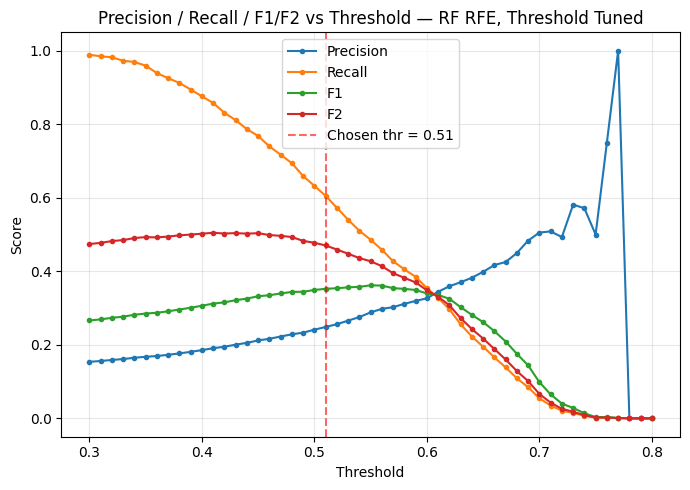

In [32]:
# Threshold curves
plt.figure(figsize=(7,5))
plt.plot(thr_df["threshold"], thr_df["precision"], label="Precision", marker="o", ms=3)
plt.plot(thr_df["threshold"], thr_df["recall"],    label="Recall",    marker="o", ms=3)
plt.plot(thr_df["threshold"], thr_df["f1"],        label="F1",        marker="o", ms=3)
plt.plot(thr_df["threshold"], thr_df["f2"],        label="F2",        marker="o", ms=3)
plt.axvline(t, color="r", linestyle="--", alpha=0.6, label=f"Chosen thr = {t:.2f}")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision / Recall / F1/F2 vs Threshold — RF RFE, Threshold Tuned")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

Accuracy: 0.6559
ROC-AUC: 0.7058
F1-Score: 0.3492

Accuracy Tr: 0.6653
ROC-AUC Tr: 0.7289
F1-Score Tr: 0.3664



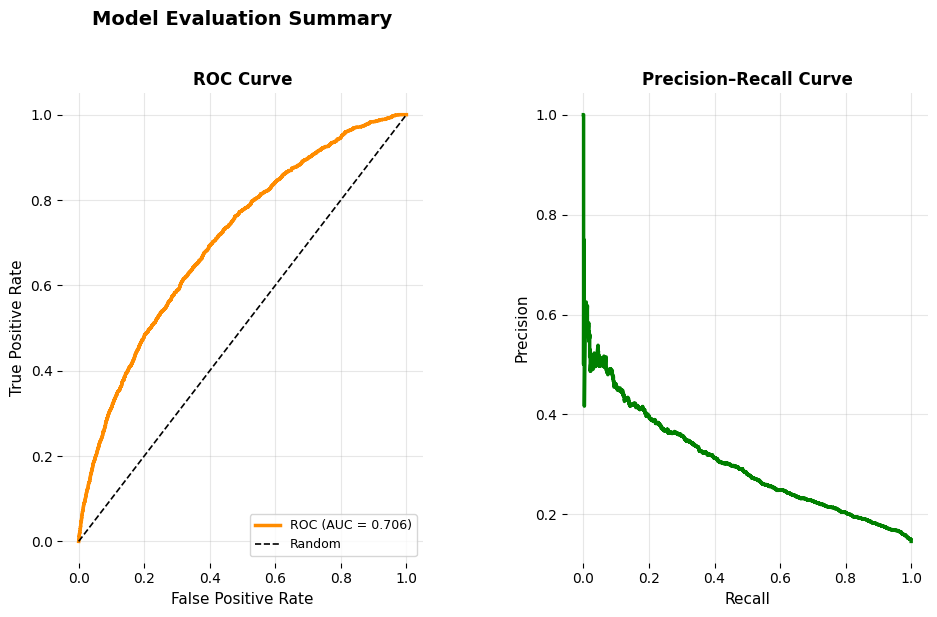

In [33]:
plt.figure(figsize=(14, 6))       # wider layout for 3 plots
best_rf_f2_rfe = rand_search_f2_opt_rfe.best_estimator_
y_pred_f2_rfe_opt = best_rf_f2_rfe.predict(X_test_rfe)
y_pred_f2_rfe_opt_proba = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
y_tr_pred_f2_rfe_opt = best_rf_f2_rfe.predict(X_train_rfe)
y_tr_pred_f2_rfe_opt_proba = best_rf_f2_rfe.predict_proba(X_train_rfe)[:, 1]
print(f"Accuracy: {accuracy_score(y_test, y_pred_f2_rfe_opt):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_f2_rfe_opt_proba):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_f2_rfe_opt):.4f}\n")
print(f"Accuracy Tr: {accuracy_score(y_train, y_tr_pred_f2_rfe_opt):.4f}")
print(f"ROC-AUC Tr: {roc_auc_score(y_train, y_tr_pred_f2_rfe_opt_proba):.4f}")
print(f"F1-Score Tr: {f1_score(y_train, y_tr_pred_f2_rfe_opt):.4f}\n")
# --- 6. ROC Curve ---
ax6 = plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_f2_rfe_opt_proba)
roc_auc = roc_auc_score(y_test, y_pred_f2_rfe_opt_proba)
ax6.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})', lw=2.5, color='darkorange')
ax6.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Random')
ax6.set_xlabel('False Positive Rate', fontsize=11)
ax6.set_ylabel('True Positive Rate', fontsize=11)
ax6.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9, loc='lower right')
ax6.grid(alpha=0.3)
for spine in ax6.spines.values():
    spine.set_visible(False)

# --- 7. Precision–Recall Curve ---
ax7 = plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_f2_rfe_opt_proba)
ax7.plot(recall, precision, lw=2.5, color='green')
ax7.set_xlabel('Recall', fontsize=11)
ax7.set_ylabel('Precision', fontsize=11)
ax7.set_title('Precision–Recall Curve', fontsize=12, fontweight='bold')
ax7.grid(alpha=0.3)
for spine in ax7.spines.values():
    spine.set_visible(False)

# --- Overall formatting ---
plt.suptitle('Model Evaluation Summary', fontsize=14, weight='bold', y=1.02)
plt.tight_layout()                # fixes overlaps
plt.subplots_adjust(wspace=0.4)   # add breathing room between plots
plt.show()

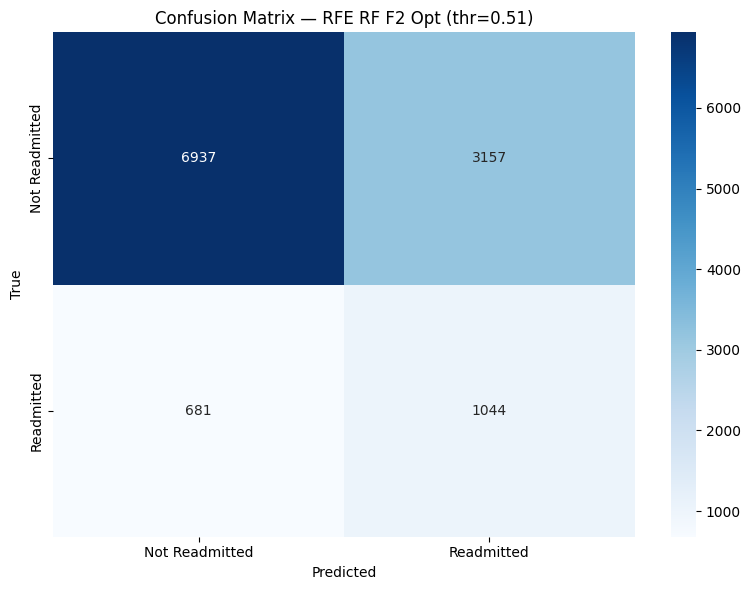

In [35]:
plt.figure(figsize=(8,6))
import seaborn as sns
sns.heatmap(cm_thr_rfe, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted','Readmitted'], yticklabels=['Not Readmitted','Readmitted'])
plt.title(f'Confusion Matrix — RFE RF F2 Opt (thr={t:.2f})'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

In [36]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf_f2_rfe)

# Compute SHAP values for test set
shap_values = explainer.shap_values(X_test_rfe)

In [37]:
# Keep only SHAP values for the positive class
shap_values_pos = shap_values[:, :, 1]

In [38]:
shap_values_pos.shape

(11819, 91)

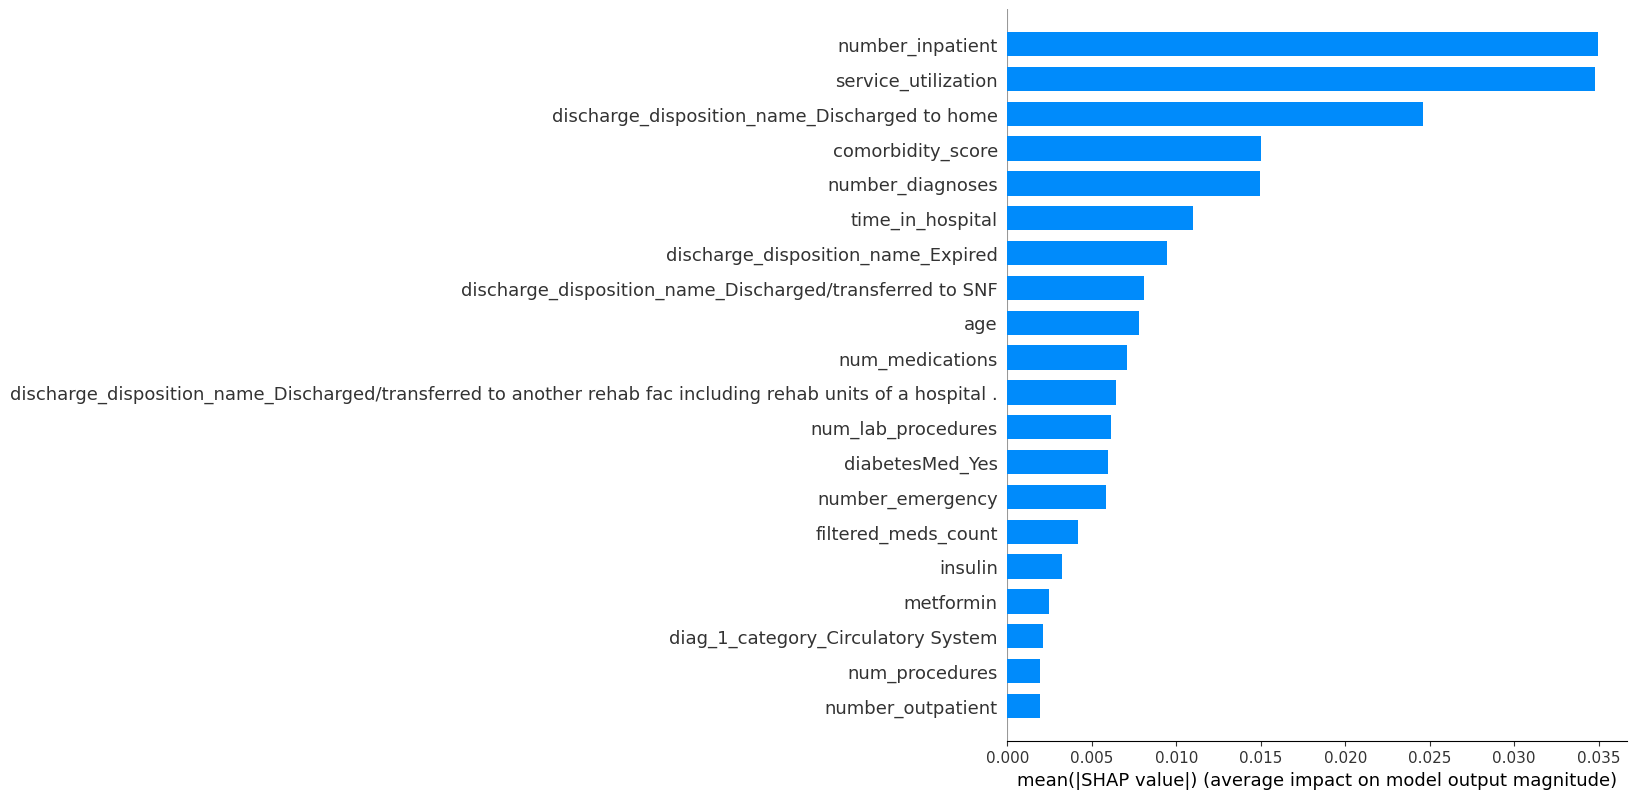

In [39]:
shap.summary_plot(shap_values_pos, X_test_rfe, plot_type="bar")

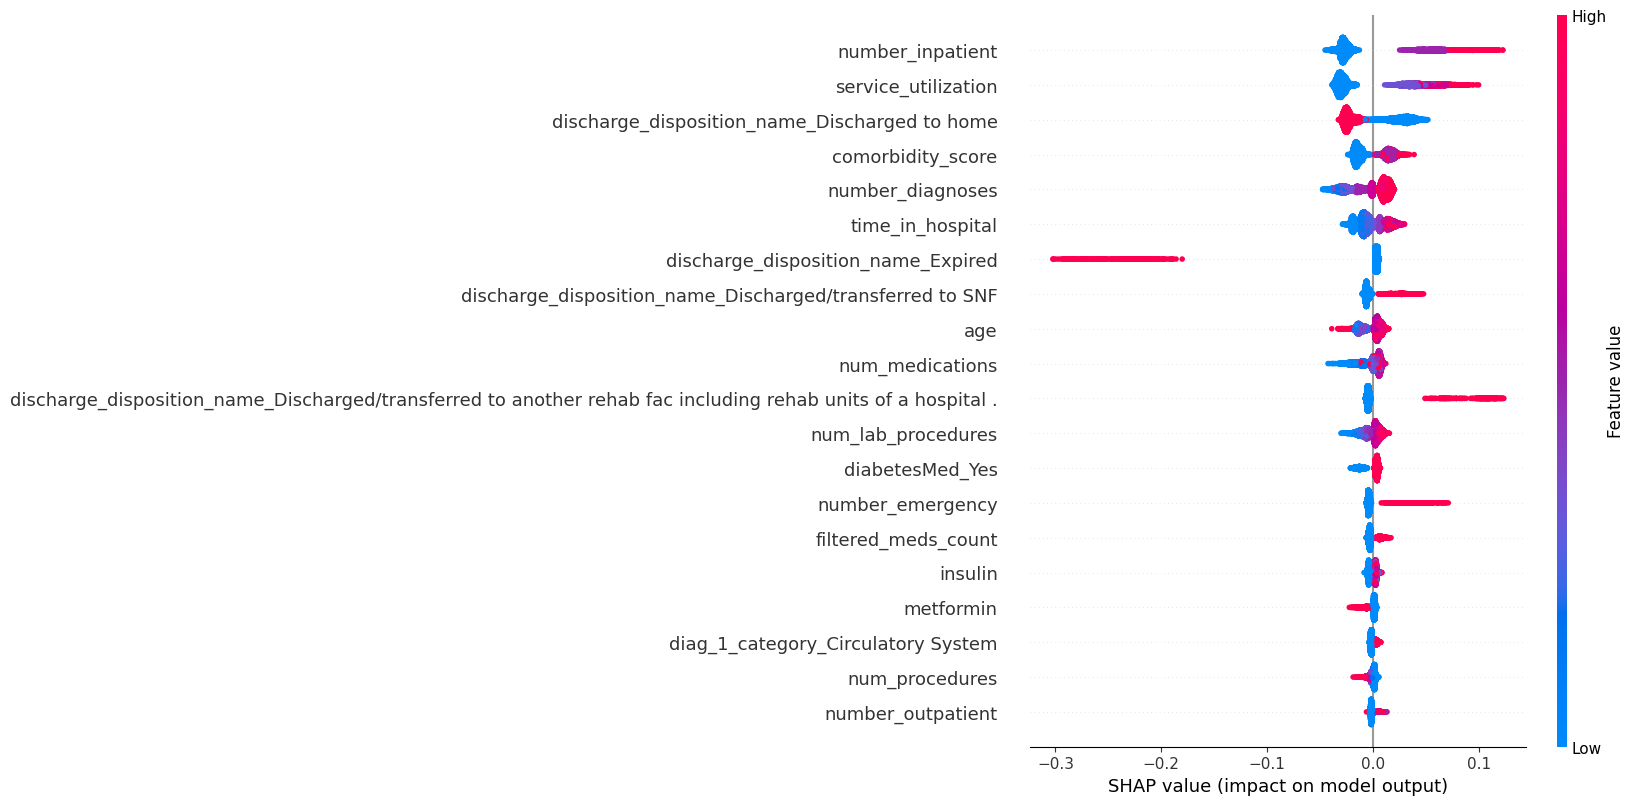

In [40]:
shap.summary_plot(shap_values_pos, X_test_rfe)

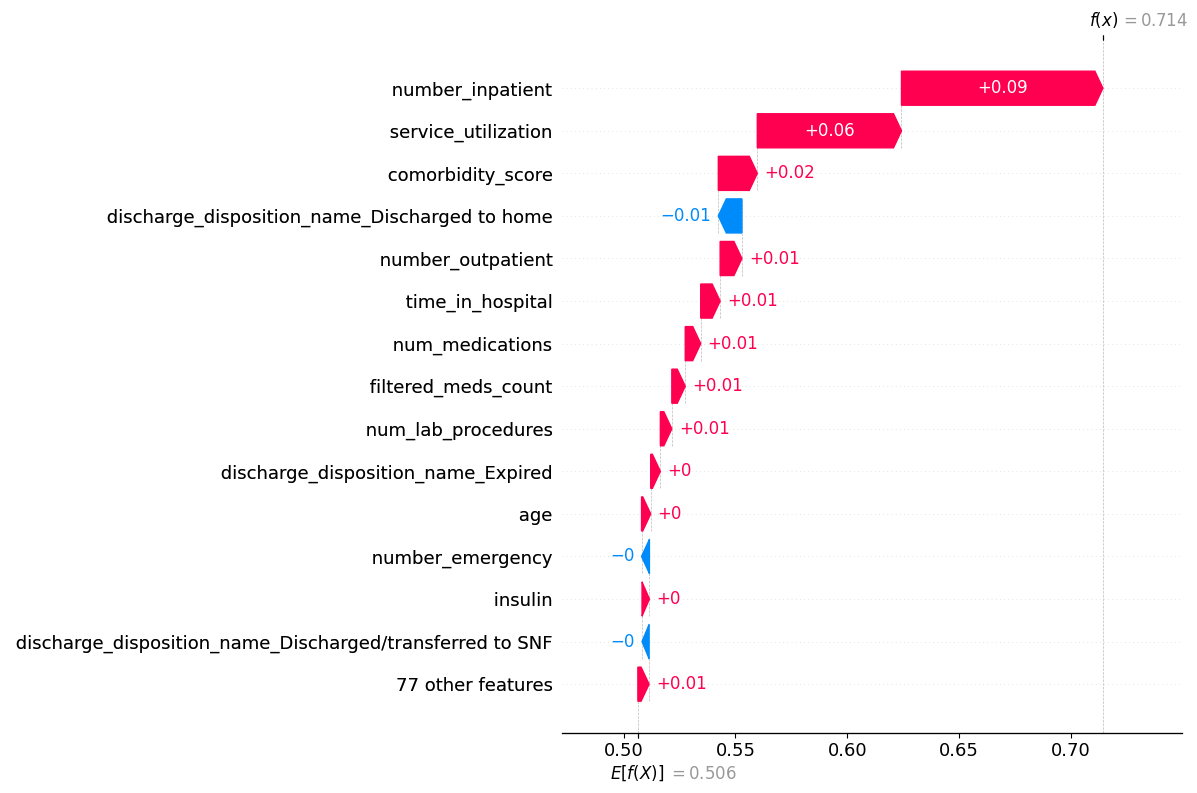

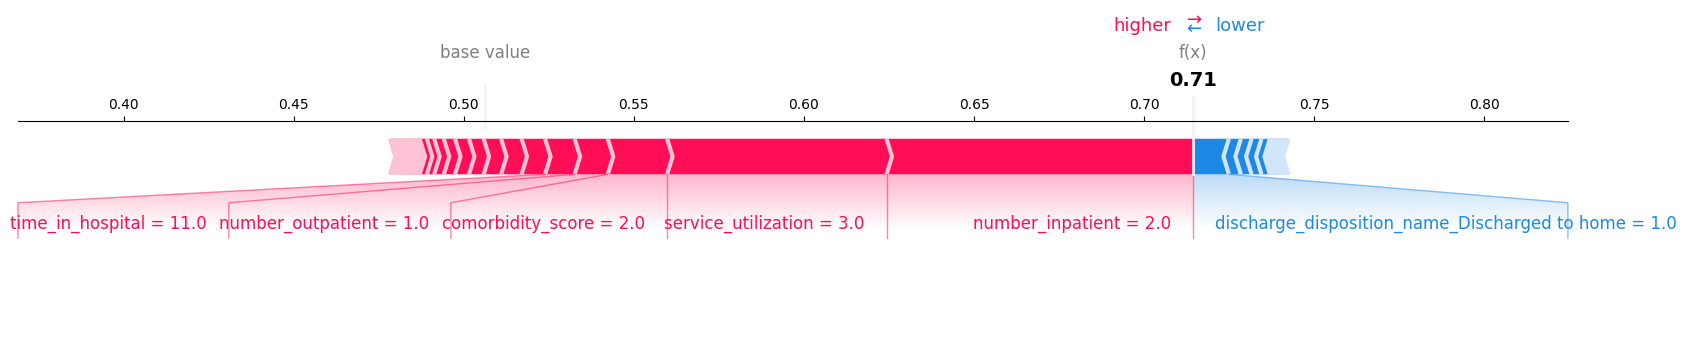

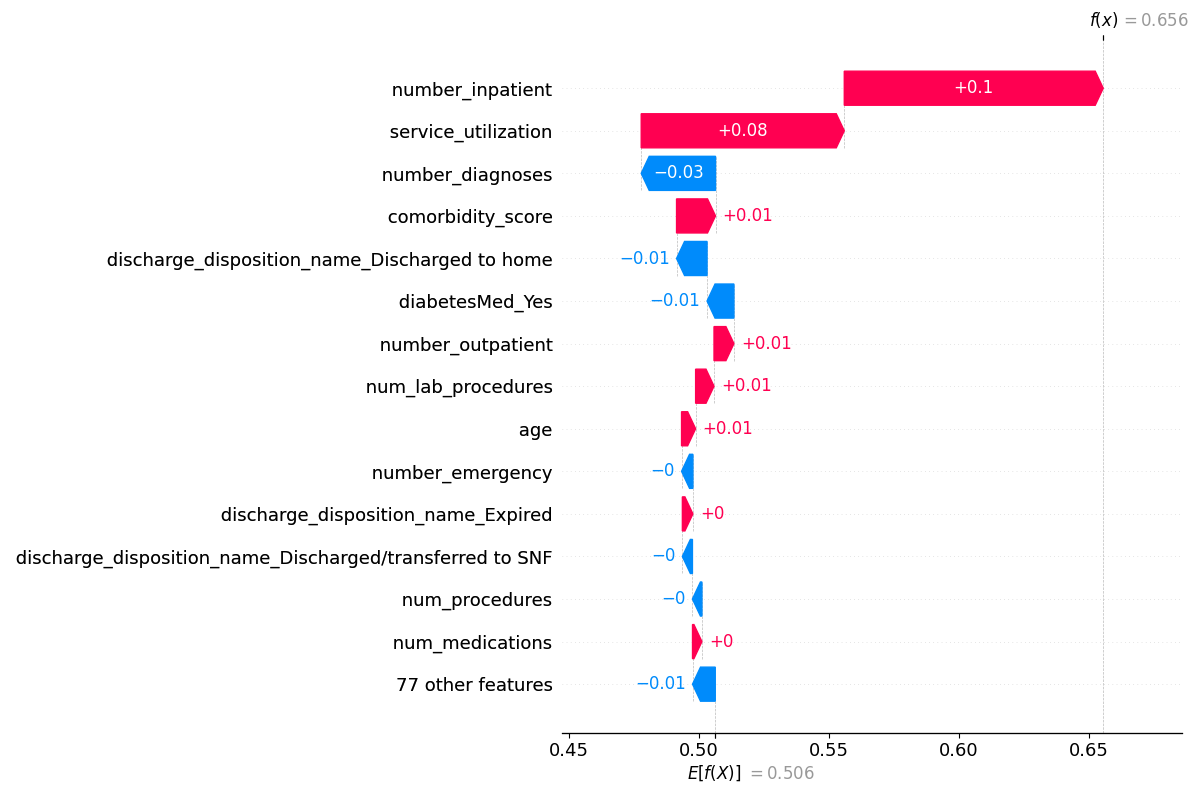

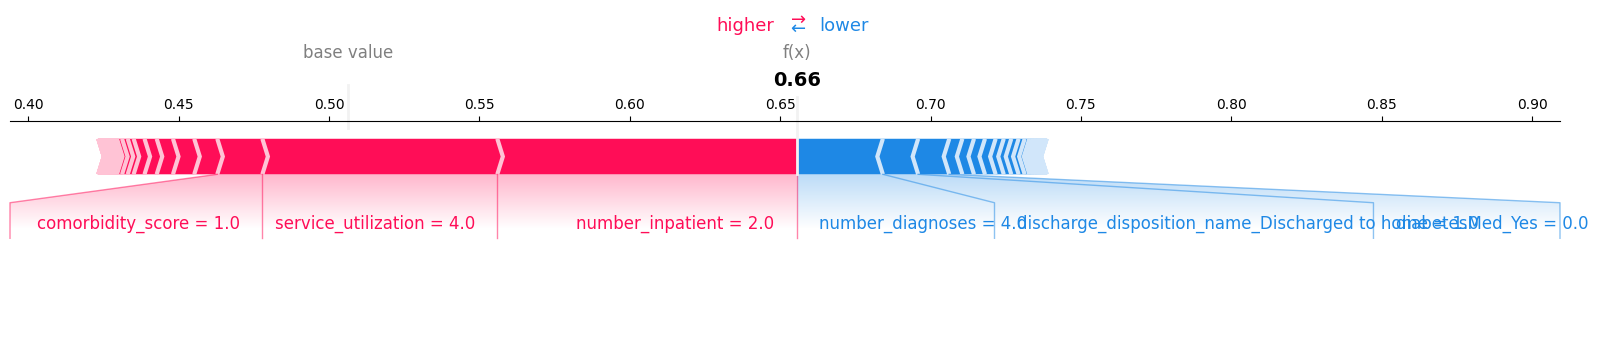

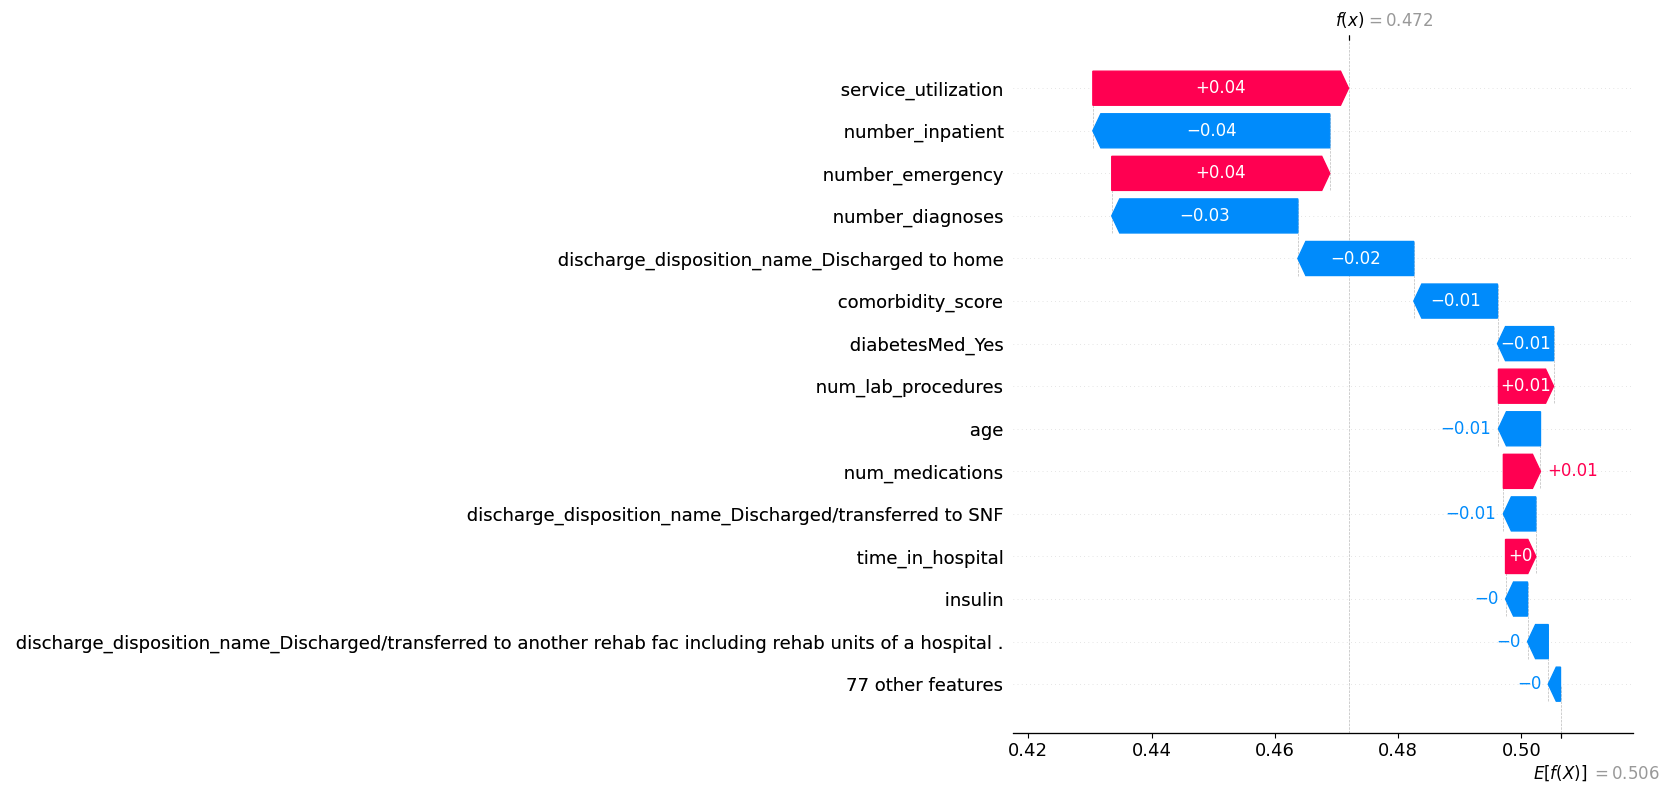

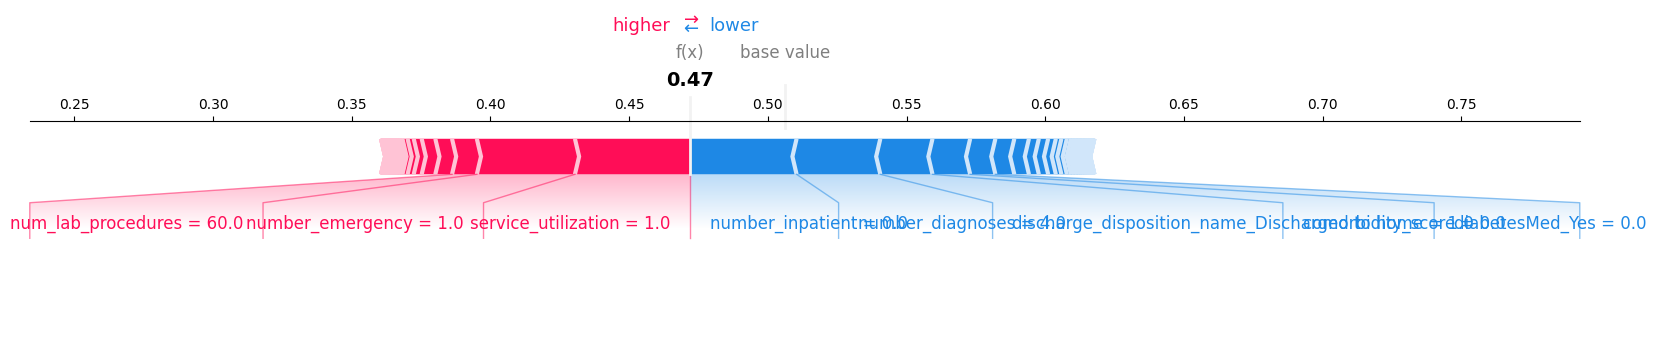

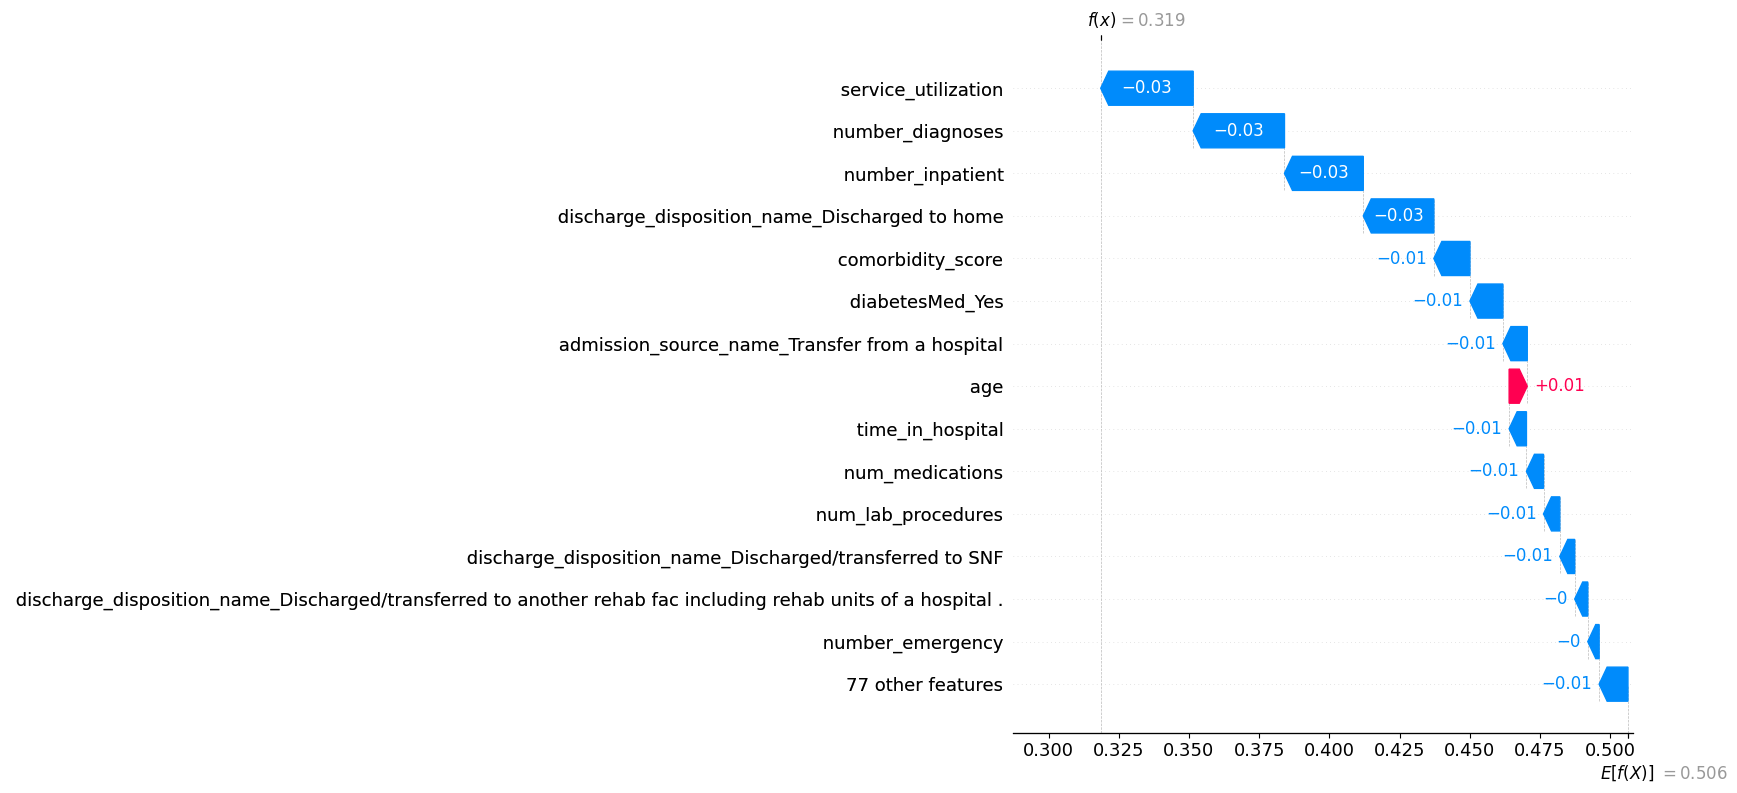

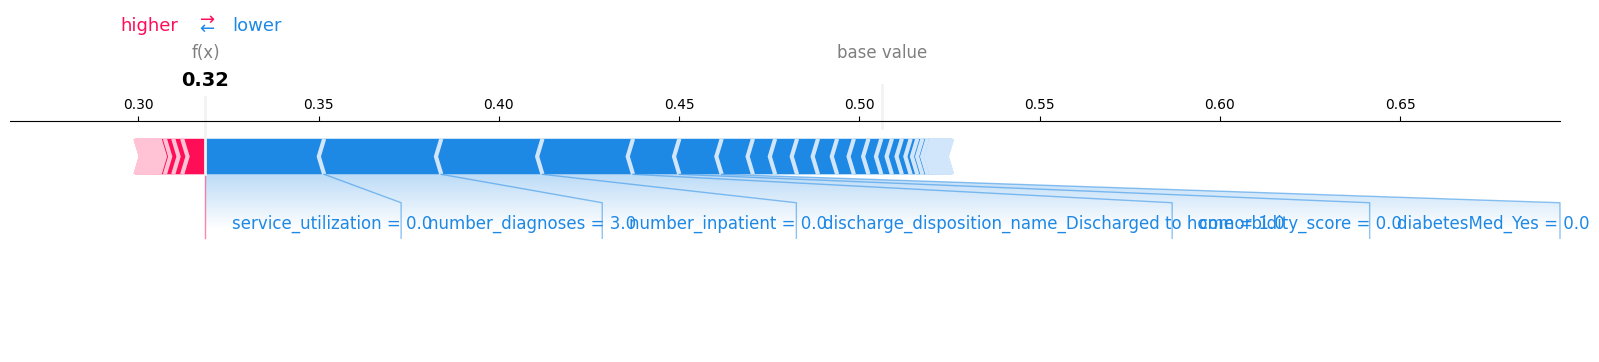

In [41]:
for i in [5, 12, 24,42]:
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[1],
        shap_values_pos[i, :],
        X_test_rfe.iloc[i, :],
        max_display = 15
    )
    shap.force_plot(
    explainer.expected_value[1],          # base value for class 1
    shap_values_pos[i, :],                # SHAP values for that instance
    X_test_rfe.iloc[i, :],                # corresponding feature values
    matplotlib=True                       # renders as static matplotlib plot
)

Classes: [0 1]
Prediction: 1
True Label: 1
Prob(Readmitted): 0.714


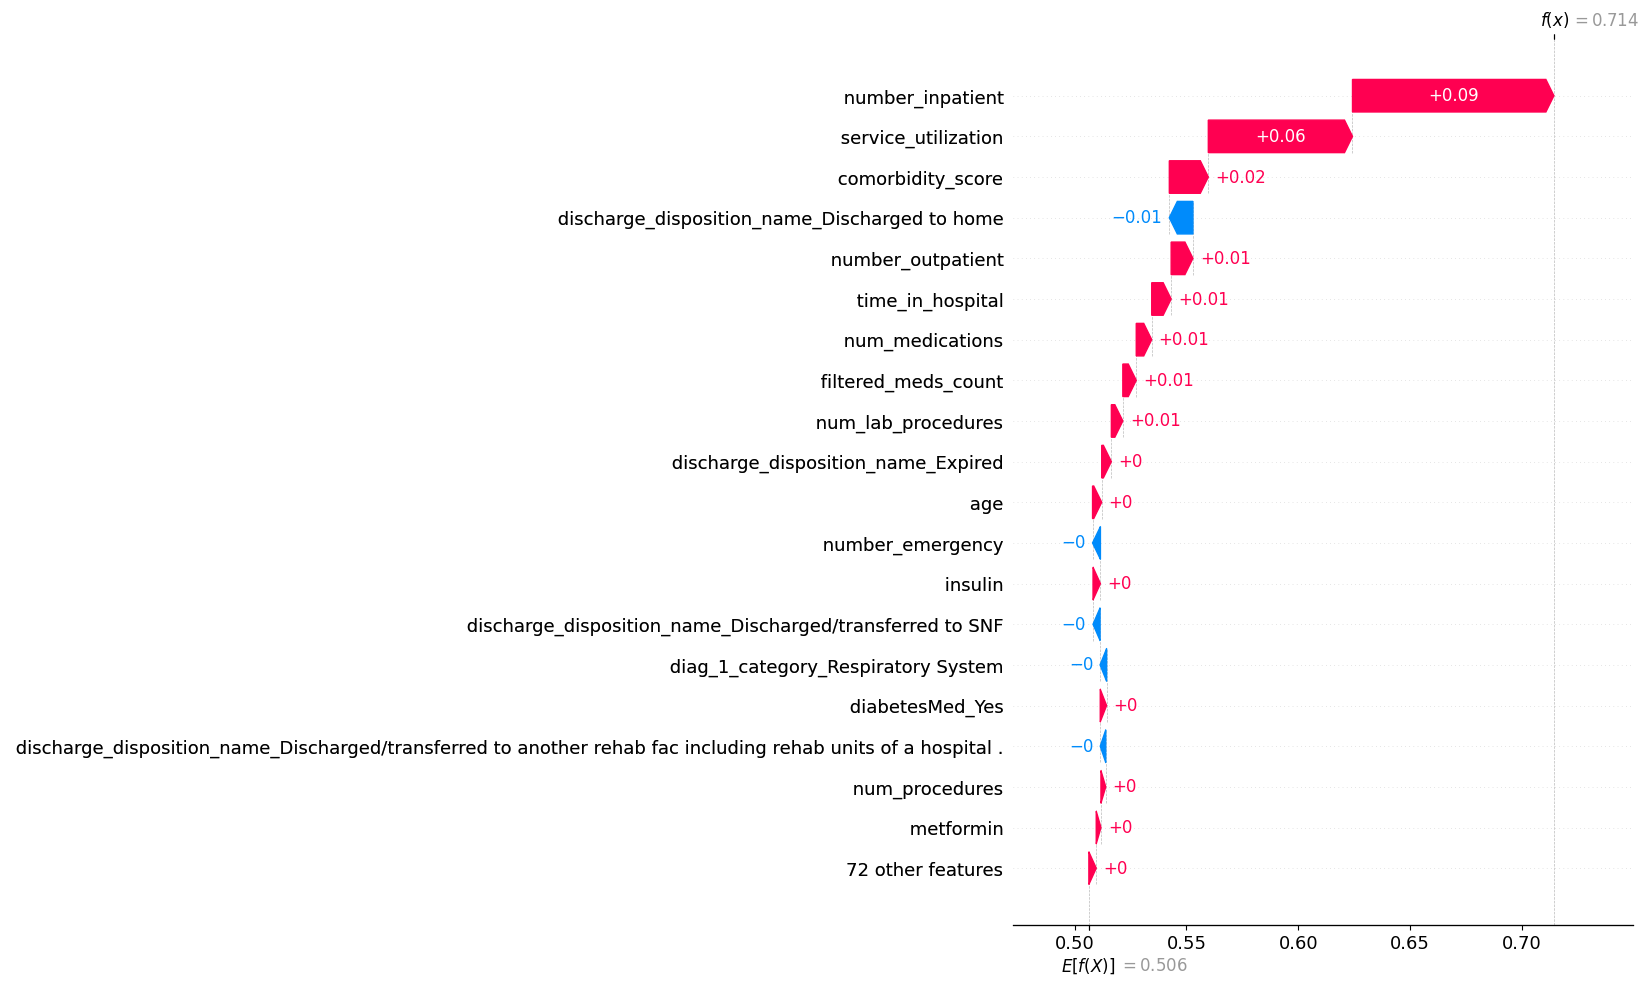

Classes: [0 1]
Prediction: 1
True Label: 0
Prob(Readmitted): 0.656


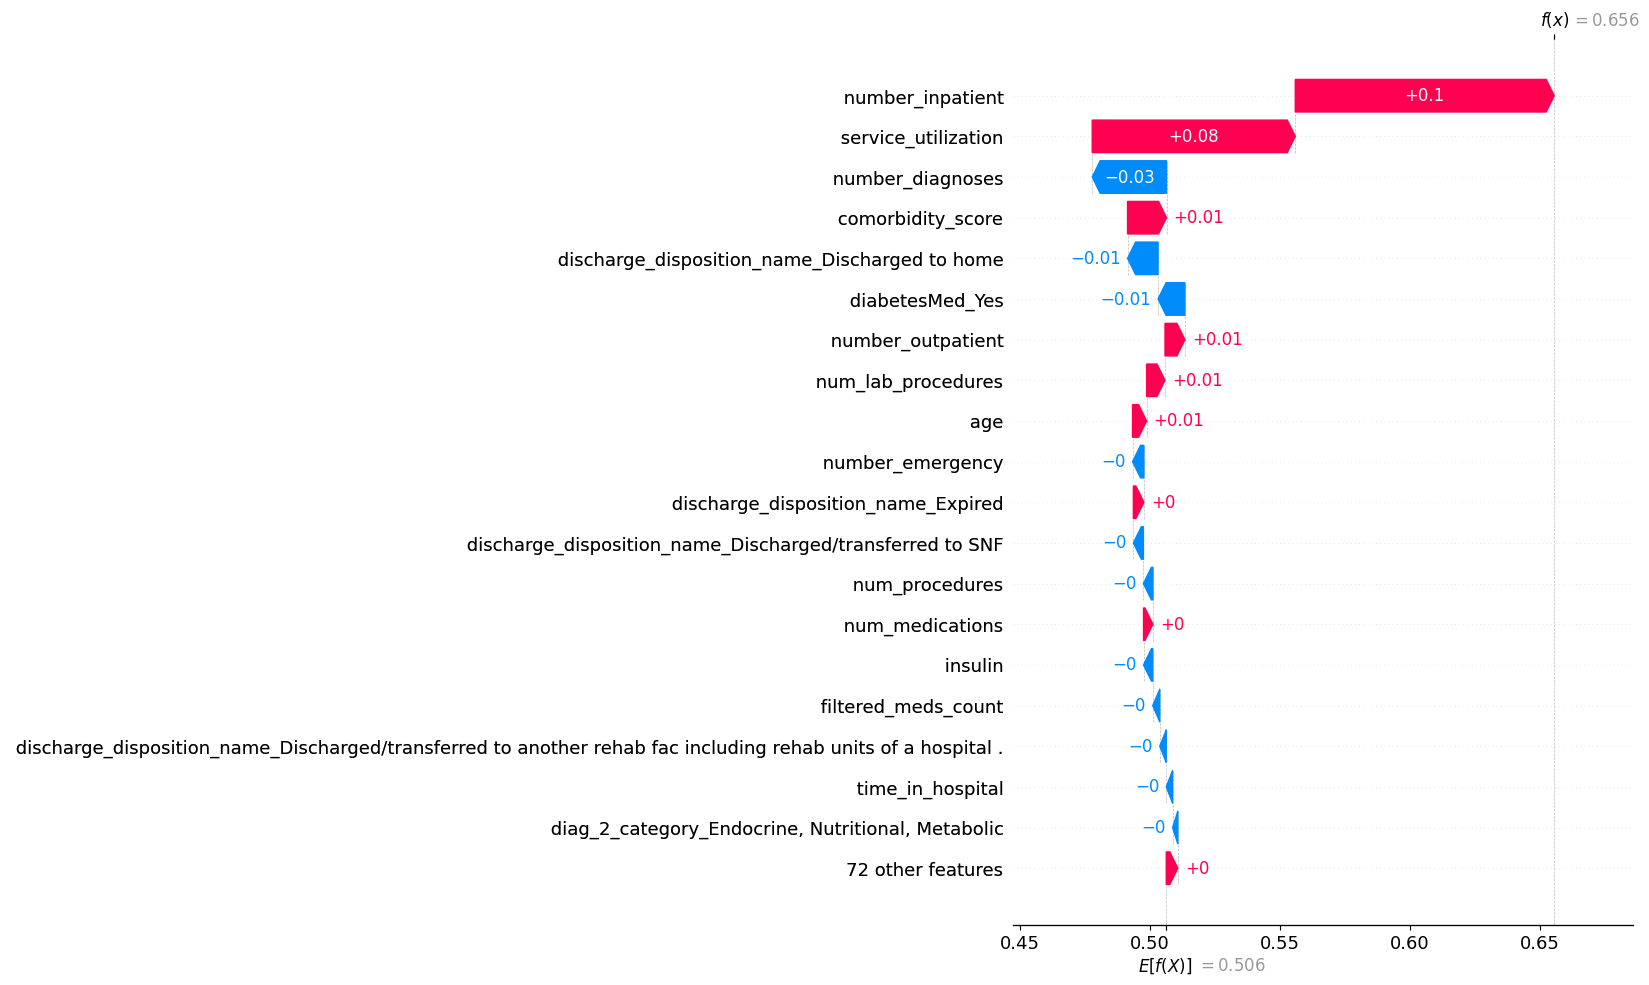

Classes: [0 1]
Prediction: 0
True Label: 0
Prob(Readmitted): 0.472


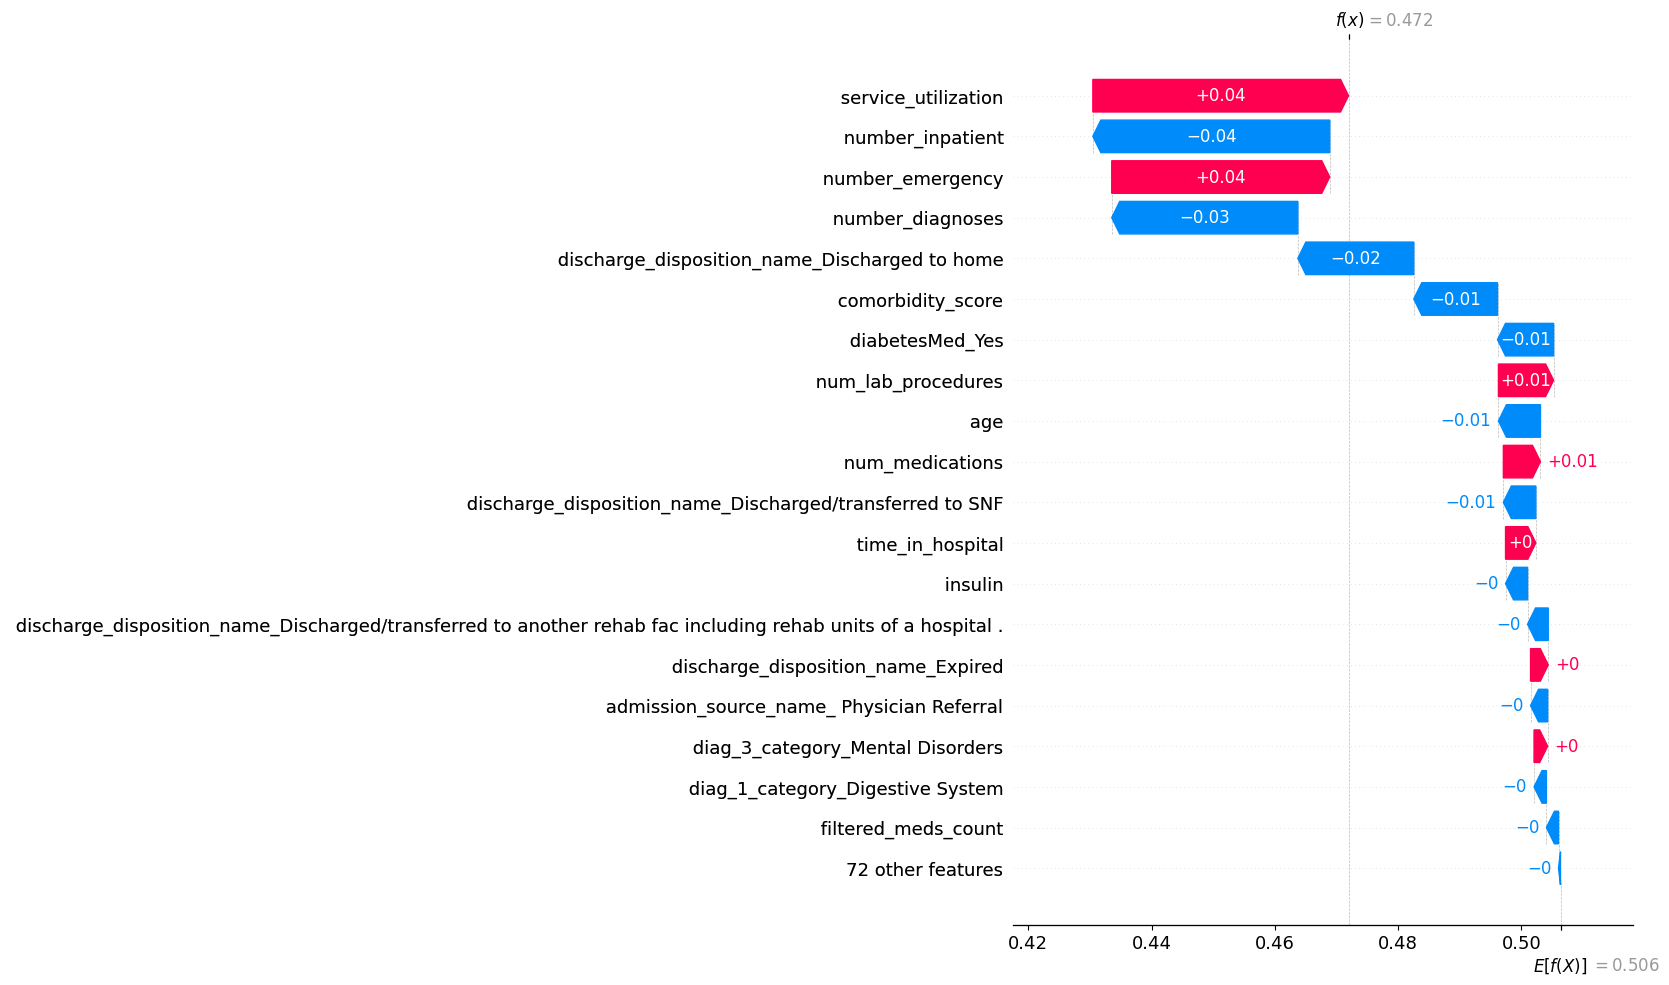

Classes: [0 1]
Prediction: 0
True Label: 0
Prob(Readmitted): 0.319


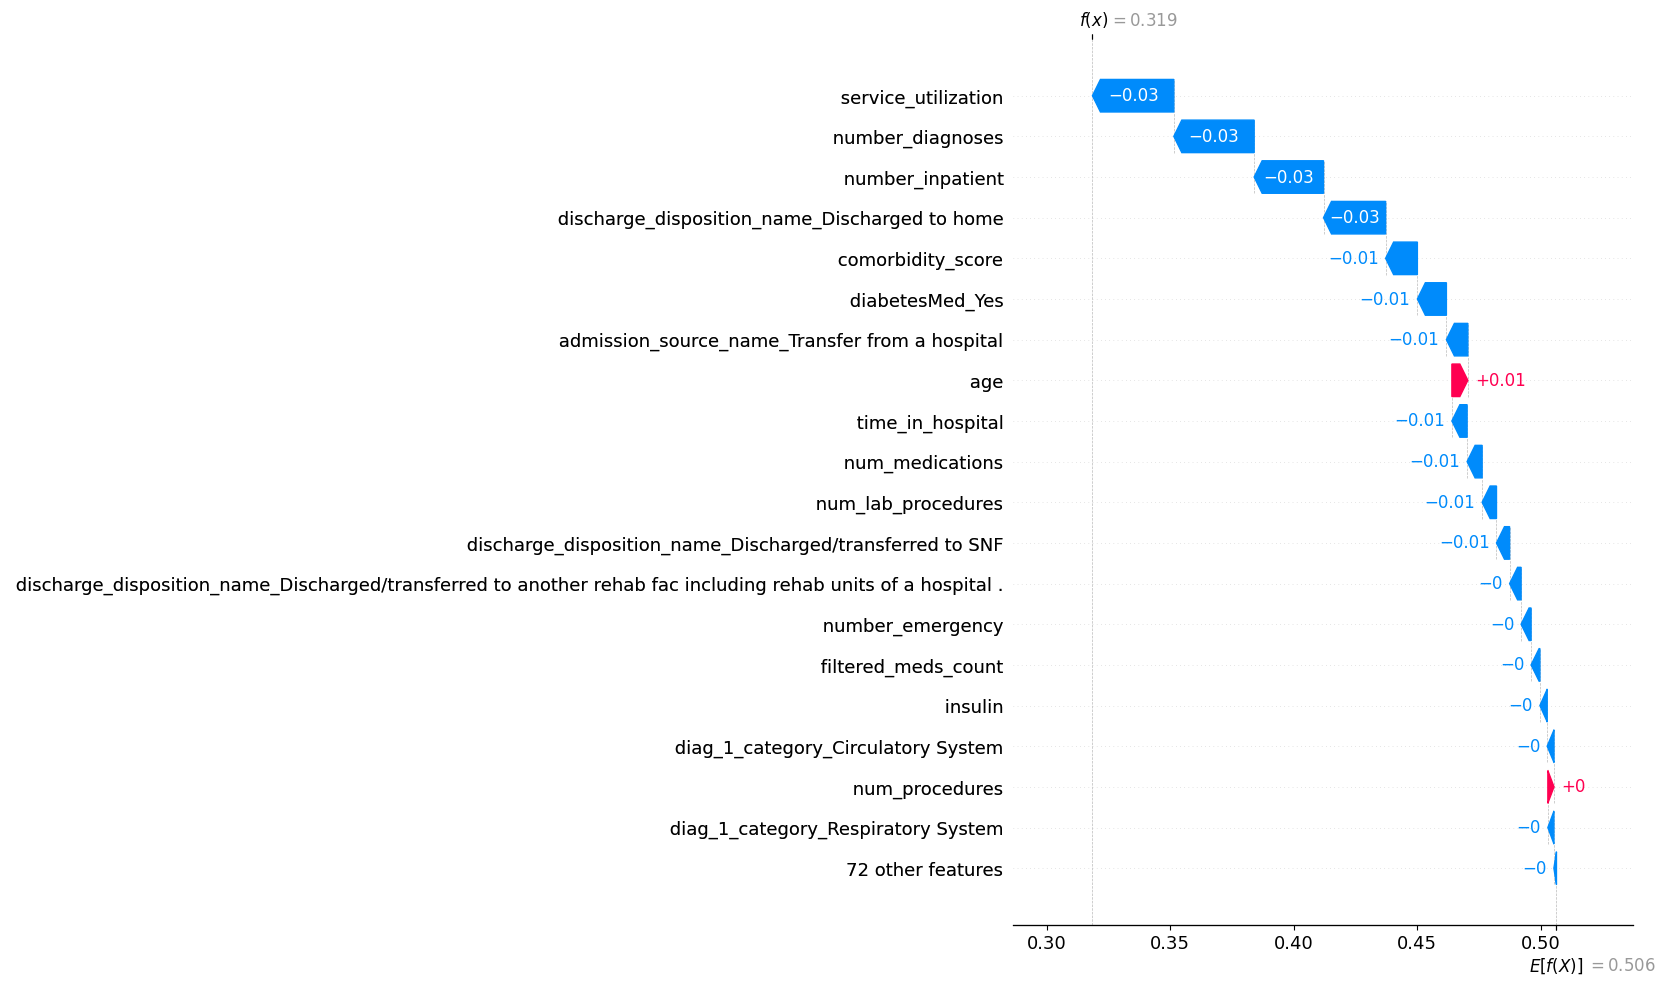

In [42]:


for i in [5, 12, 24, 42]:
    print("Classes:", best_rf_f2_rfe.classes_)
    print(f"Prediction: {best_rf_f2_rfe.predict(X_test_rfe.iloc[[i]])[0]}")
    print(f"True Label: {y_test.iloc[i]}")
    print(f"Prob(Readmitted): {best_rf_f2_rfe.predict_proba(X_test_rfe.iloc[[i]])[0,1]:.3f}")
    
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[1],
        shap_values_pos[i, :],
        X_test_rfe.iloc[i, :],
        max_display = 20
    )

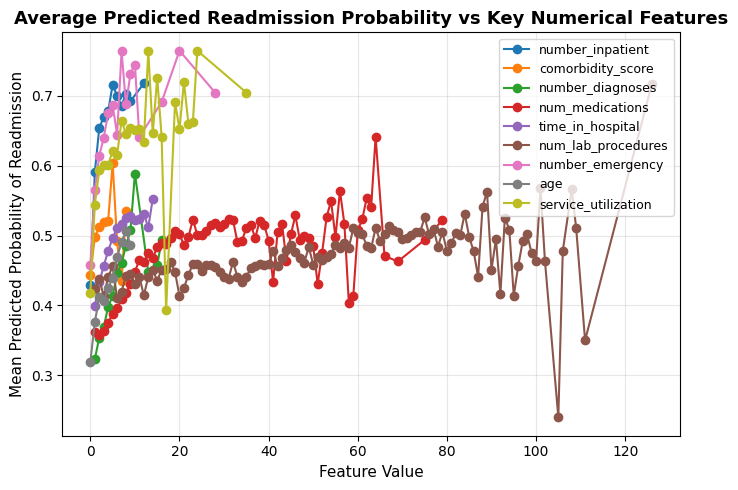

In [43]:

# Compute predicted probabilities
X_temp = X_test_rfe.copy()
X_temp["pred_prob"] = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
X_temp["comorbidity_score"] = X_test_rfe["comorbidity_score"]

# Group and plot mean predicted probability by comorbidity score
list_of_features = ["number_inpatient","comorbidity_score","number_diagnoses","num_medications","time_in_hospital","num_lab_procedures","number_emergency","age","service_utilization"]
plt.figure(figsize=(7,5))
for featur in list_of_features:
    
    df_prob = X_temp.groupby(featur)["pred_prob"].mean().reset_index()

    
    plt.plot(df_prob[featur], df_prob["pred_prob"], marker='o', label=featur)
plt.xlabel("Feature Value", fontsize=11)
plt.ylabel("Mean Predicted Probability of Readmission", fontsize=11)
plt.title("Average Predicted Readmission Probability vs Key Numerical Features", fontsize=13, weight='bold')
plt.legend(fontsize=9, loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

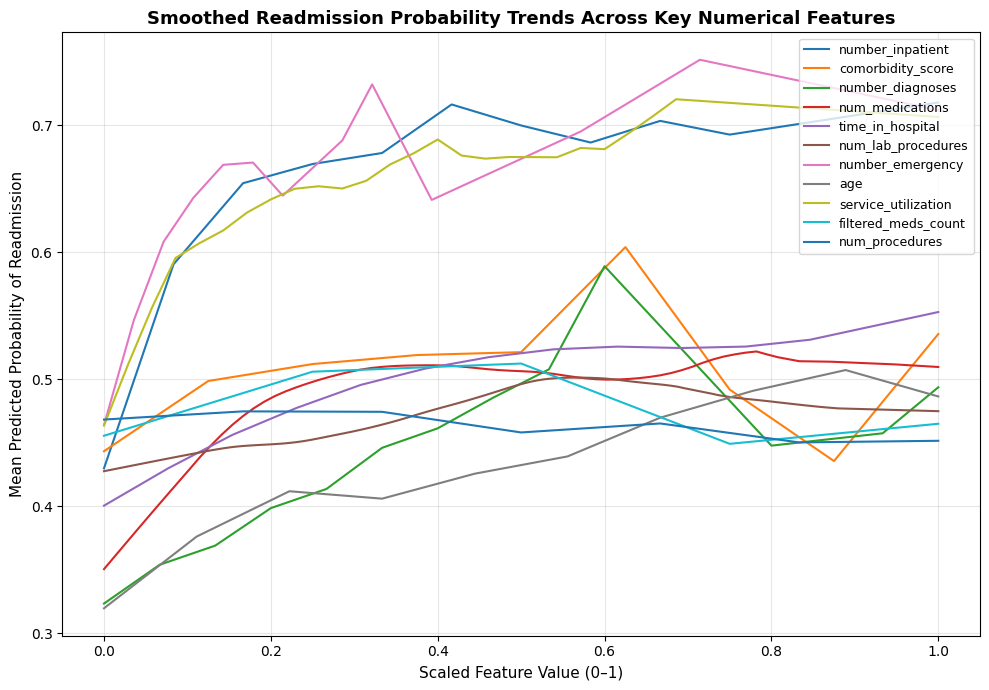

In [44]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

# Copy and compute predicted probabilities
X_temp = X_test_rfe.copy()
X_temp["pred_prob"] = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]

# Features to plot
features = [
    "number_inpatient", "comorbidity_score", "number_diagnoses",
    "num_medications", "time_in_hospital", "num_lab_procedures",
    "number_emergency", "age", "service_utilization", "filtered_meds_count", "num_procedures"
]

# Min–Max scale for trend comparison
scaler = MinMaxScaler()
X_scaled_temp = X_temp.copy()
X_scaled_temp[features] = scaler.fit_transform(X_scaled_temp[features])

plt.figure(figsize=(10, 7))

for feature in features:
    df_prob = X_scaled_temp.groupby(feature)["pred_prob"].mean().reset_index()
    
    # LOWESS smoothing
    smoothed = lowess(df_prob["pred_prob"], df_prob[feature], frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=feature)

plt.xlabel("Scaled Feature Value (0–1)", fontsize=11)
plt.ylabel("Mean Predicted Probability of Readmission", fontsize=11)
plt.title("Smoothed Readmission Probability Trends Across Key Numerical Features", fontsize=13, weight='bold')
plt.legend(fontsize=9, loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


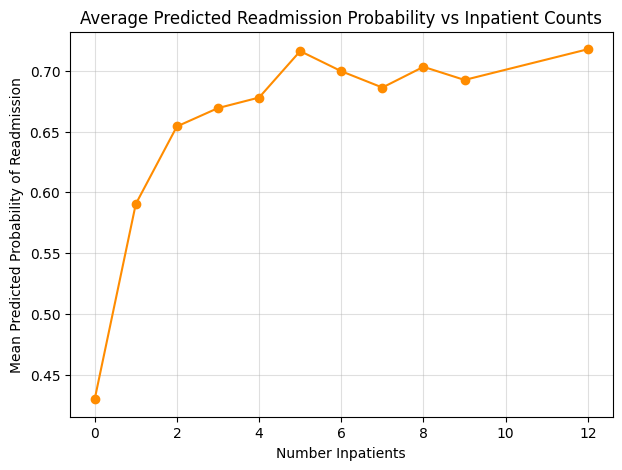

In [45]:
# Compute predicted probabilities
X_temp = X_test_rfe.copy()
X_temp["pred_prob"] = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
X_temp["number_inpatient"] = X_test_rfe["number_inpatient"]

# Group and plot mean predicted probability by comorbidity score
df_prob = X_temp.groupby("number_inpatient")["pred_prob"].mean().reset_index()

plt.figure(figsize=(7,5))
plt.plot(df_prob["number_inpatient"], df_prob["pred_prob"], marker='o', color='darkorange')
plt.xlabel("Number Inpatients")
plt.ylabel("Mean Predicted Probability of Readmission")
plt.title("Average Predicted Readmission Probability vs Inpatient Counts")
plt.grid(alpha=0.4)
plt.show()

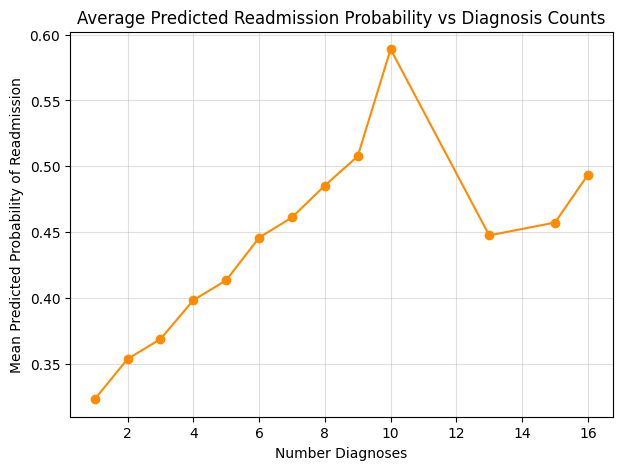

In [46]:
# Compute predicted probabilities
X_temp = X_test_rfe.copy()
X_temp["pred_prob"] = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
X_temp["number_diagnoses"] = X_test_rfe["number_diagnoses"]

# Group and plot mean predicted probability by comorbidity score
df_prob = X_temp.groupby("number_diagnoses")["pred_prob"].mean().reset_index()

plt.figure(figsize=(7,5))
plt.plot(df_prob["number_diagnoses"], df_prob["pred_prob"], marker='o', color='darkorange')
plt.xlabel("Number Diagnoses")
plt.ylabel("Mean Predicted Probability of Readmission")
plt.title("Average Predicted Readmission Probability vs Diagnosis Counts")
plt.grid(alpha=0.4)
plt.show()

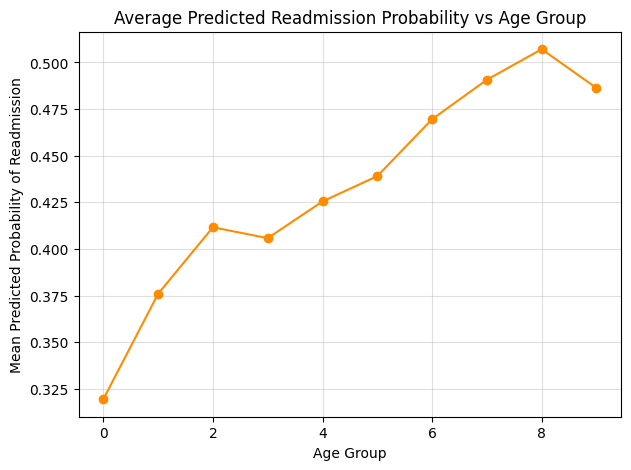

In [47]:
# Compute predicted probabilities
X_temp = X_test_rfe.copy()
X_temp["pred_prob"] = best_rf_f2_rfe.predict_proba(X_test_rfe)[:, 1]
X_temp["age"] = X_test_rfe["age"]

# Group and plot mean predicted probability by comorbidity score
df_prob = X_temp.groupby("age")["pred_prob"].mean().reset_index()

plt.figure(figsize=(7,5))
plt.plot(df_prob["age"], df_prob["pred_prob"], marker='o', color='darkorange')
plt.xlabel("Age Group")
plt.ylabel("Mean Predicted Probability of Readmission")
plt.title("Average Predicted Readmission Probability vs Age Group")
plt.grid(alpha=0.4)
plt.show()

In [51]:

preds = np.stack([t.predict(X_train_rfe) for t in best_rf_f2_rfe.estimators_])
rf_pred = np.round(preds.mean(axis=0))
diffs = (preds != rf_pred).mean(axis=1)
most_representative_idx = np.argmin(diffs)
print("Most representative tree index:", most_representative_idx)

Most representative tree index: 153


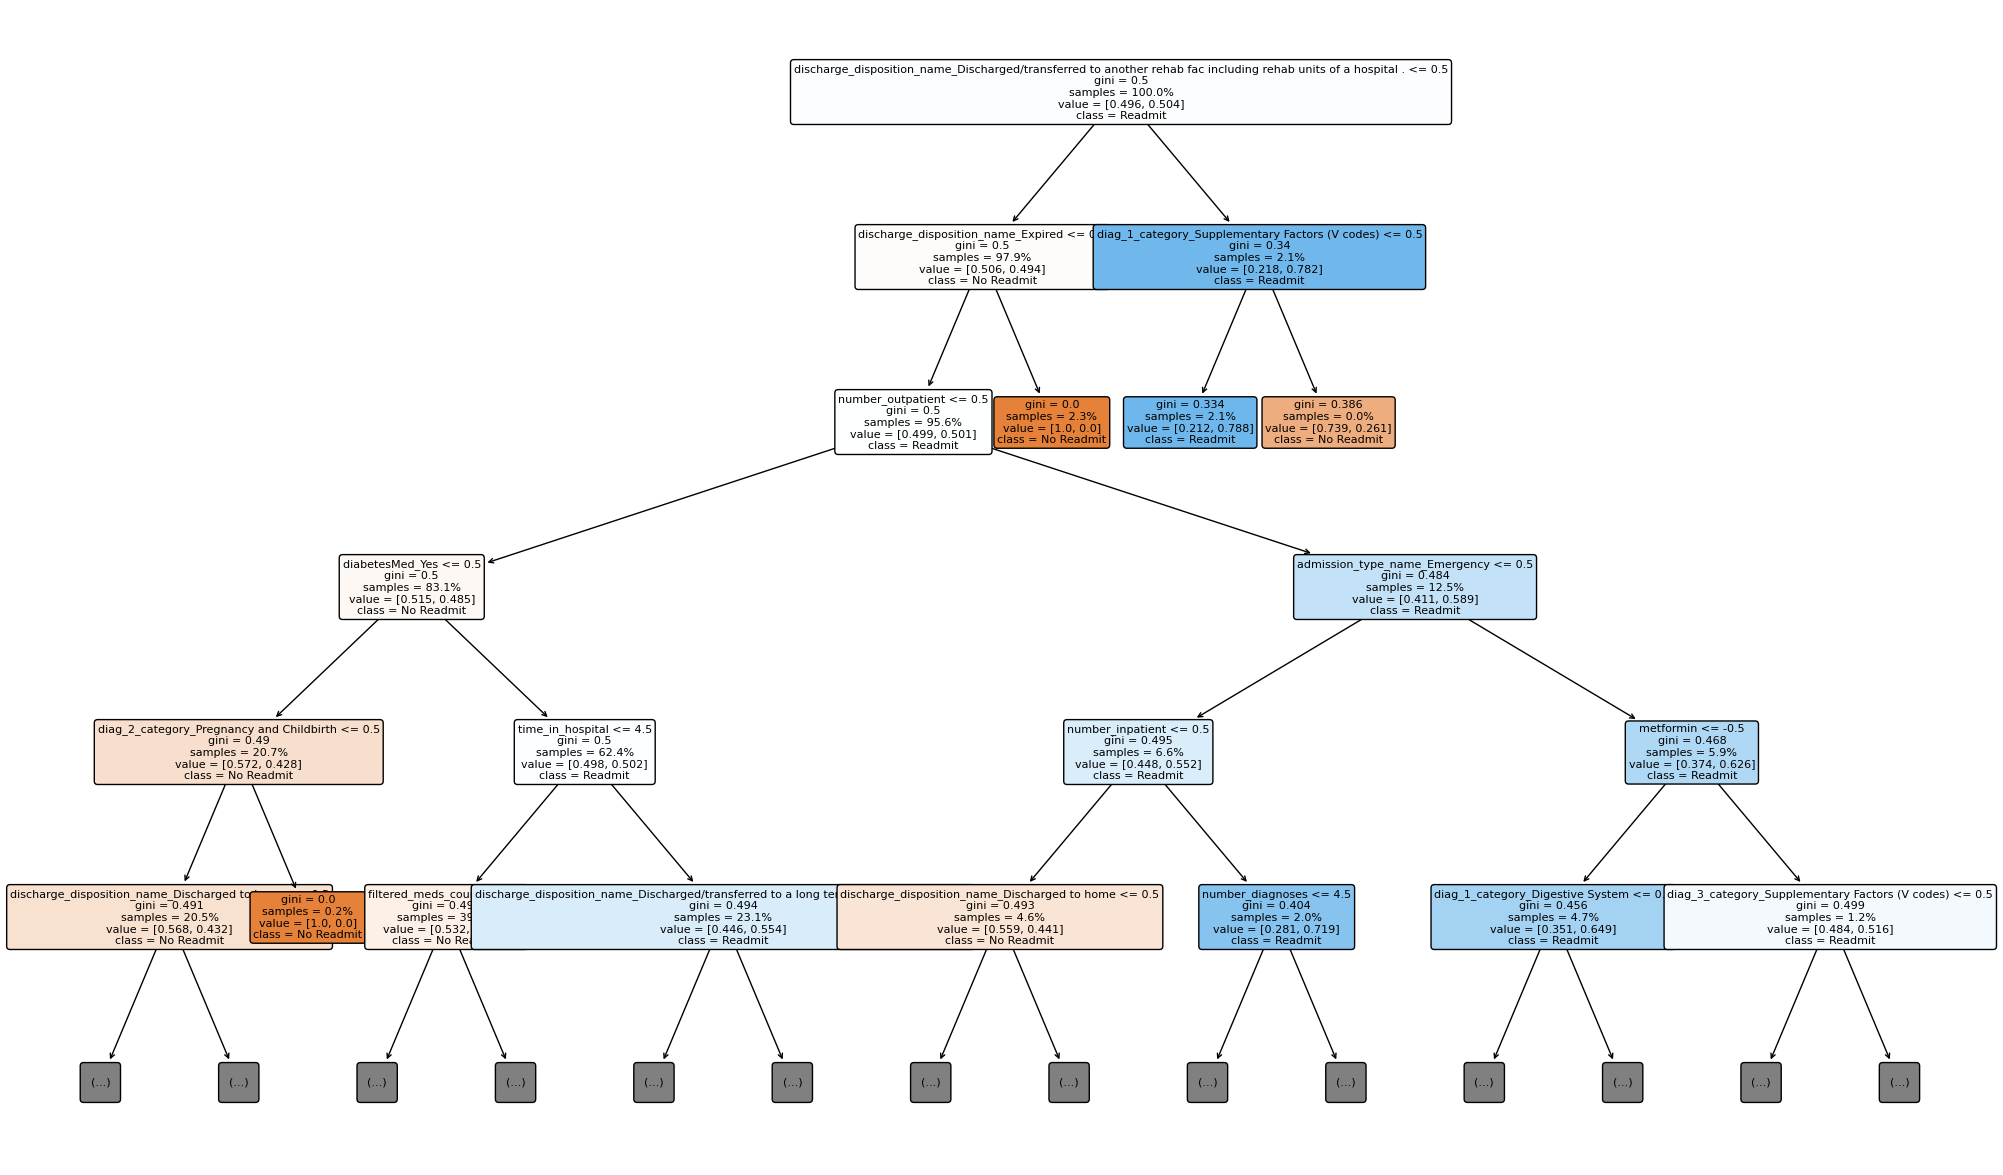

In [54]:

single_tree = best_rf_f2_rfe.estimators_[153]
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 15))
plot_tree(
    single_tree,
    feature_names=X_train_rfe.columns,
    class_names=["No Readmit", "Readmit"],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth = 5,
    proportion=True
)
plt.show()